# TESS Atlas fit for TOI 248

**Version: 0.1.0**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 248.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-248.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-248.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.0/toi-248.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 248

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 248 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

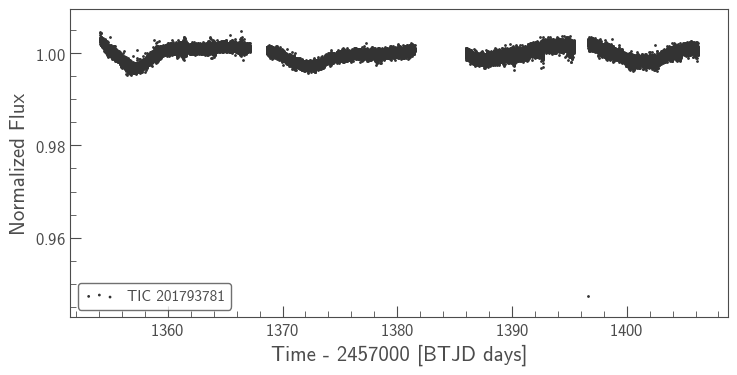

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all()
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])    
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -50632.52138905173 -> -46573.04395528465


In [6]:
diag

array([0.18883245, 0.18892643, 0.1886844 , ..., 0.18549356, 0.1853808 ,
       0.18569721])

## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [7]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -32971.652450825095 -> -32172.376101524624


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -32172.37610152462 -> -32094.440323753504


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -32094.440323753504 -> -32094.438489081123


optimizing logp for variables: ['mean', 't0', 'logP']


message: Optimization terminated successfully.
logp: -32094.438489081123 -> -32092.907184111504


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -32092.907184111504 -> -32092.669646588354


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -32092.669646588354 -> -32090.13878592909


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -32090.1387859291 -> -32090.1387859291


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -32090.13878592909 -> -32090.13878592909


optimizing logp for variables: ['logg_star']


message: Desired error not necessarily achieved due to precision loss.
logp: -32090.13878592909 -> -32090.13878592909


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -32090.13878592909 -> -32090.138785929088


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -32090.138785929088 -> -32090.138785929088


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -32090.138785929088 -> -32090.13878592908


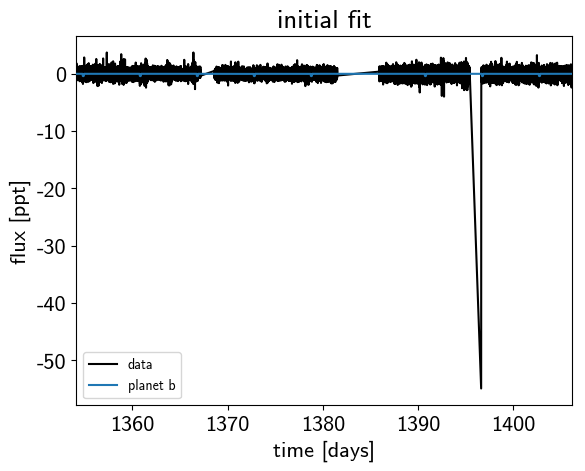

In [8]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [9]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:09, 10.45draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:01<00:16,  5.87draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:24,  3.82draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:02<00:29,  3.08draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:02<00:32,  2.84draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:03<00:36,  2.49draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:03<00:36,  2.47draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:03<00:37,  2.37draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:04<00:41,  2.09draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:04<00:33,  2.57draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:05<00:40,  2.11draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:05<00:38,  2.17draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:06<00:36,  2.30draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:06<00:35,  2.31draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:06<00:32,  2.47draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:07<00:33,  2.42draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:07<00:31,  2.52draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:08<00:31,  2.51draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:08<00:29,  2.60draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:08<00:30,  2.51draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:09<00:28,  2.65draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:09<00:29,  2.47draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:10<00:28,  2.60draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:10<00:30,  2.33draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:10<00:26,  2.73draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:11<00:29,  2.38draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:11<00:24,  2.80draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:12<00:28,  2.38draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:12<00:23,  2.80draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:12<00:27,  2.44draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:13<00:23,  2.77draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:13<00:26,  2.45draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:14<00:25,  2.48draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:15<00:24,  2.47draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:16<00:23,  2.51draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:16<00:21,  2.56draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:16<00:17,  3.21draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:17<00:21,  2.51draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:18<00:20,  2.52draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:18<00:16,  3.07draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:19<00:21,  2.37draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:19<00:16,  2.95draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:19<00:19,  2.42draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:20<00:16,  2.86draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:20<00:18,  2.42draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:20<00:15,  2.84draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:21<00:17,  2.50draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:21<00:15,  2.80draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:22<00:16,  2.48draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:22<00:15,  2.70draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:23<00:17,  2.25draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:23<00:14,  2.60draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:23<00:18,  2.11draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:24<00:16,  2.26draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:24<00:15,  2.30draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:24<00:12,  2.89draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:25<00:16,  2.11draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:25<00:12,  2.74draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:26<00:14,  2.15draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:26<00:11,  2.71draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:27<00:13,  2.20draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:27<00:13,  2.23draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:27<00:11,  2.46draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:28<00:13,  1.93draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:29<00:11,  2.10draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:29<00:08,  2.72draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:30<00:10,  2.25draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:30<00:08,  2.74draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:31<00:08,  2.37draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:31<00:07,  2.59draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:31<00:07,  2.50draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:32<00:07,  2.29draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:32<00:06,  2.69draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:33<00:07,  2.13draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:34<00:06,  2.18draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:34<00:05,  2.24draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:35<00:05,  2.18draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:35<00:04,  2.45draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:36<00:05,  1.71draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:37<00:04,  1.72draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:37<00:02,  2.21draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:38<00:02,  1.83draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:39<00:02,  1.81draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:40<00:02,  1.32draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:41<00:01,  1.14draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:42<00:00,  1.25draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:46<00:00,  1.81s/draws]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:00<00:01, 59.68draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:14,  6.20draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:24,  3.64draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:30,  2.96draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:03<00:30,  2.86draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:33,  2.62draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:04<00:35,  2.46draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:04<00:32,  2.60draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:04<00:38,  2.17draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:05<00:29,  2.79draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:05<00:39,  2.06draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:06<00:37,  2.14draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:06<00:30,  2.62draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:07<00:23,  3.27draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:07<00:35,  2.15draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:08<00:28,  2.64draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:08<00:35,  2.09draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:08<00:28,  2.62draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:09<00:38,  1.91draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:10<00:34,  2.06draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:11<00:31,  2.16draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:12<00:29,  2.24draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:12<00:22,  2.95draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:13<00:29,  2.16draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:13<00:23,  2.70draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:14<00:32,  1.89draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:15<00:30,  1.98draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:15<00:27,  2.16draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:15<00:27,  2.09draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:16<00:32,  1.75draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:17<00:29,  1.88draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:18<00:26,  1.98draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:18<00:20,  2.52draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:19<00:24,  2.10draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:19<00:20,  2.46draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:20<00:23,  2.11draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:20<00:19,  2.45draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:21<00:23,  2.04draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:21<00:18,  2.49draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:22<00:17,  2.57draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:22<00:14,  3.01draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:22<00:17,  2.40draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:23<00:15,  2.72draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:23<00:17,  2.32draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:24<00:16,  2.43draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:24<00:12,  3.01draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:24<00:17,  2.15draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:25<00:15,  2.21draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:25<00:12,  2.81draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:26<00:15,  2.16draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:27<00:14,  2.22draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:27<00:15,  2.03draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:28<00:13,  2.22draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:28<00:14,  2.04draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:28<00:12,  2.29draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:29<00:13,  1.93draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:29<00:11,  2.36draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:30<00:13,  1.88draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:31<00:11,  2.01draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:32<00:10,  2.07draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:32<00:07,  2.46draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:33<00:07,  2.37draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:33<00:07,  2.31draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:33<00:05,  2.98draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:34<00:06,  2.31draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:34<00:04,  2.78draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:35<00:05,  2.23draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:35<00:04,  2.72draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:36<00:04,  2.04draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:37<00:03,  2.02draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:38<00:02,  2.06draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:38<00:01,  2.55draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:39<00:01,  2.16draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:39<00:01,  1.75draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:40<00:01,  1.47draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:42<00:00,  1.16draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:44<00:00,  1.28s/draws]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<02:54,  1.16draws/s]

Sampling 2 chains:   1%|          | 2/204 [00:00<02:09,  1.56draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:01<01:33,  2.14draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<01:19,  2.49draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:02<01:53,  1.75draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:02<01:31,  2.15draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:03<01:31,  2.15draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:03<01:43,  1.89draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:03<01:24,  2.30draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:04<01:48,  1.78draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:04<01:21,  2.36draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:05<01:08,  2.81draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:05<00:54,  3.46draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:06<01:03,  2.94draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:06<01:16,  2.43draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:07<01:09,  2.67draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:07<01:35,  1.92draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:08<01:15,  2.44draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:08<01:01,  2.94draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:08<01:16,  2.37draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:09<01:24,  2.14draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:09<01:24,  2.12draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:10<01:04,  2.75draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:10<01:25,  2.07draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:11<01:11,  2.48draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:11<00:58,  2.99draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:12<01:26,  2.02draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:12<01:15,  2.31draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:12<01:15,  2.29draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:12<00:58,  2.90draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:13<01:29,  1.91draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:14<01:07,  2.50draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:14<00:57,  2.92draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:14<01:10,  2.36draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:15<01:14,  2.23draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:15<01:17,  2.13draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:16<01:22,  1.98draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:16<01:23,  1.95draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:17<01:26,  1.87draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:18<01:23,  1.93draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:18<01:05,  2.43draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:19<01:31,  1.73draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:19<01:15,  2.10draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:19<01:07,  2.32draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:20<01:10,  2.21draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:20<01:10,  2.18draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:20<00:54,  2.82draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:21<00:54,  2.79draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:21<00:44,  3.42draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:21<00:54,  2.75draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:22<01:06,  2.25draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:22<00:58,  2.53draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:23<01:19,  1.86draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:23<00:59,  2.46draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:24<01:20,  1.81draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:25<01:11,  2.03draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:26<01:23,  1.72draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:26<01:02,  2.27draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:26<00:52,  2.68draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:26<00:45,  3.05draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:27<01:02,  2.19draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:27<00:51,  2.63draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:28<00:45,  2.94draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:28<00:43,  3.10draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:28<00:35,  3.75draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:28<00:35,  3.69draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:29<01:04,  2.02draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:30<00:48,  2.68draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:31<00:51,  2.48draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:31<00:43,  2.91draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:31<00:40,  3.05draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:32<00:40,  3.03draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:33<01:02,  1.94draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:33<00:50,  2.38draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:34<01:00,  1.99draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:34<00:49,  2.38draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:34<00:44,  2.67draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:34<00:36,  3.18draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:35<00:32,  3.57draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:35<00:36,  3.11draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:35<00:34,  3.25draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:36<00:40,  2.78draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:36<00:41,  2.68draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:36<00:32,  3.38draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:36<00:27,  3.95draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:37<00:28,  3.78draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:37<00:23,  4.46draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:37<00:25,  4.17draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:38<00:30,  3.34draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:38<00:22,  4.47draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:39<00:18,  5.32draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:39<00:38,  2.51draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:40<00:35,  2.70draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:40<00:31,  2.95draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:41<00:29,  3.15draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:41<00:32,  2.80draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:42<00:29,  3.02draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:42<00:24,  3.57draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:42<00:22,  3.87draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:42<00:23,  3.71draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:43<00:24,  3.45draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:43<00:30,  2.82draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:43<00:30,  2.78draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:44<00:40,  2.04draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:45<00:31,  2.55draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:45<00:35,  2.24draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:45<00:30,  2.61draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:46<00:29,  2.61draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:46<00:34,  2.23draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:47<00:35,  2.14draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:47<00:30,  2.44draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:47<00:25,  2.86draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:48<00:32,  2.27draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:48<00:30,  2.39draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:49<00:38,  1.82draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:50<00:33,  2.03draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:50<00:32,  2.06draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:51<00:35,  1.89draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:52<00:34,  1.92draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:52<00:26,  2.38draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:52<00:20,  3.03draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:53<00:32,  1.91draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:53<00:23,  2.54draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:53<00:20,  2.93draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:54<00:21,  2.72draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:54<00:16,  3.40draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:54<00:14,  3.77draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:55<00:21,  2.51draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:55<00:16,  3.22draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:55<00:16,  3.24draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:56<00:15,  3.29draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:56<00:20,  2.43draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:56<00:15,  3.14draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:57<00:19,  2.51draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:58<00:22,  2.14draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:58<00:16,  2.79draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:59<00:26,  1.76draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:59<00:23,  1.94draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [01:00<00:21,  1.99draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [01:00<00:17,  2.40draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [01:01<00:19,  2.07draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [01:01<00:19,  2.04draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [01:02<00:19,  2.04draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [01:02<00:13,  2.77draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [01:02<00:10,  3.41draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [01:02<00:09,  3.56draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [01:03<00:09,  3.61draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [01:03<00:14,  2.29draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [01:04<00:11,  2.84draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [01:05<00:16,  1.84draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [01:05<00:14,  2.11draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [01:06<00:14,  1.98draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [01:07<00:13,  1.99draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [01:07<00:10,  2.38draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [01:08<00:11,  2.16draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [01:08<00:11,  2.00draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [01:10<00:15,  1.40draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [01:10<00:11,  1.70draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [01:11<00:09,  2.03draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [01:11<00:10,  1.71draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [01:12<00:12,  1.38draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [01:13<00:09,  1.69draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [01:14<00:10,  1.38draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [01:15<00:12,  1.14draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [01:16<00:12,  1.02draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [01:17<00:10,  1.15draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [01:18<00:08,  1.20draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [01:20<00:08,  1.05draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [01:21<00:08,  1.06s/draws]

Sampling 2 chains:  97%|█████████▋| 197/204 [01:21<00:06,  1.15draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [01:22<00:04,  1.25draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [01:22<00:03,  1.50draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [01:23<00:03,  1.18draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [01:24<00:02,  1.26draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [01:25<00:01,  1.31draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [01:26<00:00,  1.12draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [01:27<00:00,  1.16draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 4/404 [00:00<00:10, 38.81draws/s]

Sampling 2 chains:   2%|▏         | 7/404 [00:00<00:11, 35.36draws/s]

Sampling 2 chains:   2%|▏         | 9/404 [00:00<00:15, 24.89draws/s]

Sampling 2 chains:   3%|▎         | 12/404 [00:00<00:15, 26.05draws/s]

Sampling 2 chains:   4%|▍         | 16/404 [00:00<00:13, 27.81draws/s]

Sampling 2 chains:   5%|▍         | 20/404 [00:00<00:12, 30.05draws/s]

Sampling 2 chains:   6%|▌         | 24/404 [00:00<00:12, 30.57draws/s]

Sampling 2 chains:   7%|▋         | 30/404 [00:00<00:11, 32.81draws/s]

Sampling 2 chains:   8%|▊         | 34/404 [00:01<00:11, 31.64draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:01<00:12, 30.26draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:01<00:11, 31.94draws/s]

Sampling 2 chains:  11%|█▏        | 46/404 [00:01<00:11, 30.00draws/s]

Sampling 2 chains:  12%|█▏        | 50/404 [00:01<00:11, 31.54draws/s]

Sampling 2 chains:  13%|█▎        | 54/404 [00:01<00:10, 32.57draws/s]

Sampling 2 chains:  14%|█▍        | 58/404 [00:01<00:11, 31.44draws/s]

Sampling 2 chains:  16%|█▌        | 64/404 [00:01<00:09, 34.80draws/s]

Sampling 2 chains:  17%|█▋        | 68/404 [00:02<00:09, 35.26draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:02<00:10, 31.62draws/s]

Sampling 2 chains:  19%|█▉        | 77/404 [00:02<00:09, 35.53draws/s]

Sampling 2 chains:  20%|██        | 81/404 [00:02<00:09, 32.56draws/s]

Sampling 2 chains:  21%|██        | 85/404 [00:02<00:10, 29.34draws/s]

Sampling 2 chains:  22%|██▏       | 89/404 [00:02<00:10, 29.64draws/s]

Sampling 2 chains:  23%|██▎       | 94/404 [00:02<00:09, 32.88draws/s]

Sampling 2 chains:  25%|██▍       | 100/404 [00:03<00:08, 37.27draws/s]

Sampling 2 chains:  26%|██▌       | 105/404 [00:03<00:07, 38.59draws/s]

Sampling 2 chains:  27%|██▋       | 110/404 [00:03<00:07, 37.22draws/s]

Sampling 2 chains:  28%|██▊       | 115/404 [00:03<00:07, 39.40draws/s]

Sampling 2 chains:  30%|██▉       | 120/404 [00:03<00:07, 38.16draws/s]

Sampling 2 chains:  31%|███       | 125/404 [00:03<00:06, 40.02draws/s]

Sampling 2 chains:  32%|███▏      | 131/404 [00:03<00:06, 43.99draws/s]

Sampling 2 chains:  34%|███▍      | 138/404 [00:03<00:05, 48.53draws/s]

Sampling 2 chains:  36%|███▌      | 145/404 [00:03<00:05, 50.03draws/s]

Sampling 2 chains:  37%|███▋      | 151/404 [00:04<00:05, 45.08draws/s]

Sampling 2 chains:  39%|███▊      | 156/404 [00:04<00:05, 43.24draws/s]

Sampling 2 chains:  40%|███▉      | 161/404 [00:04<00:05, 43.01draws/s]

Sampling 2 chains:  41%|████      | 166/404 [00:04<00:05, 41.37draws/s]

Sampling 2 chains:  42%|████▏     | 171/404 [00:04<00:05, 42.79draws/s]

Sampling 2 chains:  44%|████▎     | 176/404 [00:04<00:05, 40.90draws/s]

Sampling 2 chains:  45%|████▍     | 181/404 [00:04<00:06, 36.07draws/s]

Sampling 2 chains:  46%|████▌     | 185/404 [00:05<00:06, 36.28draws/s]

Sampling 2 chains:  47%|████▋     | 190/404 [00:05<00:05, 38.17draws/s]

Sampling 2 chains:  48%|████▊     | 195/404 [00:05<00:05, 39.58draws/s]

Sampling 2 chains:  50%|████▉     | 200/404 [00:05<00:05, 39.89draws/s]

Sampling 2 chains:  51%|█████     | 205/404 [00:05<00:05, 38.06draws/s]

Sampling 2 chains:  52%|█████▏    | 209/404 [00:05<00:05, 36.80draws/s]

Sampling 2 chains:  53%|█████▎    | 213/404 [00:05<00:05, 34.23draws/s]

Sampling 2 chains:  54%|█████▎    | 217/404 [00:05<00:05, 35.25draws/s]

Sampling 2 chains:  55%|█████▍    | 221/404 [00:06<00:05, 33.88draws/s]

Sampling 2 chains:  56%|█████▌    | 225/404 [00:06<00:05, 35.14draws/s]

Sampling 2 chains:  57%|█████▋    | 231/404 [00:06<00:04, 38.48draws/s]

Sampling 2 chains:  58%|█████▊    | 236/404 [00:06<00:04, 41.03draws/s]

Sampling 2 chains:  60%|█████▉    | 241/404 [00:06<00:03, 43.00draws/s]

Sampling 2 chains:  61%|██████    | 246/404 [00:06<00:04, 38.58draws/s]

Sampling 2 chains:  62%|██████▏   | 252/404 [00:06<00:03, 39.04draws/s]

Sampling 2 chains:  64%|██████▎   | 257/404 [00:06<00:03, 40.47draws/s]

Sampling 2 chains:  65%|██████▍   | 262/404 [00:07<00:03, 38.34draws/s]

Sampling 2 chains:  66%|██████▌   | 267/404 [00:07<00:03, 40.41draws/s]

Sampling 2 chains:  67%|██████▋   | 272/404 [00:07<00:03, 42.29draws/s]

Sampling 2 chains:  69%|██████▊   | 277/404 [00:07<00:03, 32.60draws/s]

Sampling 2 chains:  70%|███████   | 283/404 [00:07<00:03, 36.67draws/s]

Sampling 2 chains:  72%|███████▏  | 290/404 [00:07<00:02, 42.61draws/s]

Sampling 2 chains:  73%|███████▎  | 295/404 [00:07<00:02, 41.13draws/s]

Sampling 2 chains:  74%|███████▍  | 300/404 [00:07<00:02, 42.09draws/s]

Sampling 2 chains:  75%|███████▌  | 305/404 [00:08<00:02, 33.18draws/s]

Sampling 2 chains:  77%|███████▋  | 310/404 [00:08<00:02, 36.05draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [00:08<00:01, 43.07draws/s]

Sampling 2 chains:  80%|████████  | 324/404 [00:08<00:01, 44.14draws/s]

Sampling 2 chains:  82%|████████▏ | 330/404 [00:08<00:01, 44.49draws/s]

Sampling 2 chains:  83%|████████▎ | 335/404 [00:08<00:01, 43.40draws/s]

Sampling 2 chains:  84%|████████▍ | 341/404 [00:08<00:01, 46.29draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [00:09<00:01, 40.38draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [00:09<00:01, 43.27draws/s]

Sampling 2 chains:  88%|████████▊ | 357/404 [00:09<00:01, 43.83draws/s]

Sampling 2 chains:  90%|████████▉ | 363/404 [00:09<00:00, 47.22draws/s]

Sampling 2 chains:  91%|█████████▏| 369/404 [00:09<00:00, 49.19draws/s]

Sampling 2 chains:  93%|█████████▎| 375/404 [00:09<00:00, 47.59draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [00:09<00:00, 45.80draws/s]

Sampling 2 chains:  95%|█████████▌| 385/404 [00:09<00:00, 46.04draws/s]

Sampling 2 chains:  97%|█████████▋| 390/404 [00:09<00:00, 46.08draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [00:10<00:00, 43.71draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [00:10<00:00, 37.60draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:10<00:00, 27.32draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/804 [00:00<00:35, 22.40draws/s]

Sampling 2 chains:   1%|          | 7/804 [00:00<00:35, 22.45draws/s]

Sampling 2 chains:   1%|          | 10/804 [00:00<00:35, 22.56draws/s]

Sampling 2 chains:   2%|▏         | 14/804 [00:00<00:31, 25.16draws/s]

Sampling 2 chains:   2%|▏         | 19/804 [00:00<00:28, 27.82draws/s]

Sampling 2 chains:   3%|▎         | 22/804 [00:00<00:28, 27.43draws/s]

Sampling 2 chains:   3%|▎         | 27/804 [00:00<00:26, 29.33draws/s]

Sampling 2 chains:   4%|▍         | 31/804 [00:01<00:25, 30.41draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:01<00:24, 32.03draws/s]

Sampling 2 chains:   5%|▍         | 39/804 [00:01<00:24, 31.51draws/s]

Sampling 2 chains:   5%|▌         | 44/804 [00:01<00:22, 34.18draws/s]

Sampling 2 chains:   6%|▌         | 49/804 [00:01<00:20, 36.29draws/s]

Sampling 2 chains:   7%|▋         | 53/804 [00:01<00:25, 29.89draws/s]

Sampling 2 chains:   7%|▋         | 57/804 [00:01<00:23, 31.45draws/s]

Sampling 2 chains:   8%|▊         | 61/804 [00:01<00:24, 30.77draws/s]

Sampling 2 chains:   8%|▊         | 65/804 [00:02<00:22, 32.39draws/s]

Sampling 2 chains:   9%|▊         | 69/804 [00:02<00:22, 32.98draws/s]

Sampling 2 chains:   9%|▉         | 74/804 [00:02<00:20, 35.80draws/s]

Sampling 2 chains:  10%|▉         | 80/804 [00:02<00:18, 39.71draws/s]

Sampling 2 chains:  11%|█         | 85/804 [00:02<00:19, 37.10draws/s]

Sampling 2 chains:  11%|█         | 89/804 [00:02<00:19, 37.18draws/s]

Sampling 2 chains:  12%|█▏        | 94/804 [00:02<00:17, 39.53draws/s]

Sampling 2 chains:  12%|█▏        | 99/804 [00:02<00:20, 34.20draws/s]

Sampling 2 chains:  13%|█▎        | 103/804 [00:03<00:19, 35.42draws/s]

Sampling 2 chains:  13%|█▎        | 107/804 [00:03<00:22, 31.04draws/s]

Sampling 2 chains:  14%|█▍        | 113/804 [00:03<00:20, 33.97draws/s]

Sampling 2 chains:  15%|█▍        | 117/804 [00:03<00:19, 35.49draws/s]

Sampling 2 chains:  15%|█▌        | 121/804 [00:03<00:19, 35.83draws/s]

Sampling 2 chains:  16%|█▌        | 128/804 [00:03<00:16, 40.86draws/s]

Sampling 2 chains:  17%|█▋        | 133/804 [00:03<00:21, 31.34draws/s]

Sampling 2 chains:  17%|█▋        | 137/804 [00:04<00:24, 27.53draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:04<00:21, 31.40draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:04<00:19, 33.05draws/s]

Sampling 2 chains:  19%|█▊        | 150/804 [00:04<00:20, 31.40draws/s]

Sampling 2 chains:  19%|█▉        | 156/804 [00:04<00:18, 35.63draws/s]

Sampling 2 chains:  20%|█▉        | 160/804 [00:04<00:18, 35.05draws/s]

Sampling 2 chains:  20%|██        | 164/804 [00:04<00:18, 34.53draws/s]

Sampling 2 chains:  21%|██        | 168/804 [00:05<00:21, 29.03draws/s]

Sampling 2 chains:  21%|██▏       | 172/804 [00:05<00:22, 28.59draws/s]

Sampling 2 chains:  22%|██▏       | 176/804 [00:05<00:22, 28.28draws/s]

Sampling 2 chains:  22%|██▏       | 180/804 [00:05<00:21, 29.46draws/s]

Sampling 2 chains:  23%|██▎       | 184/804 [00:05<00:22, 27.54draws/s]

Sampling 2 chains:  23%|██▎       | 188/804 [00:05<00:20, 30.16draws/s]

Sampling 2 chains:  24%|██▍       | 193/804 [00:05<00:17, 34.11draws/s]

Sampling 2 chains:  25%|██▍       | 200/804 [00:05<00:15, 39.10draws/s]

Sampling 2 chains:  26%|██▌       | 206/804 [00:06<00:13, 42.84draws/s]

Sampling 2 chains:  26%|██▋       | 213/804 [00:06<00:12, 46.03draws/s]

Sampling 2 chains:  27%|██▋       | 219/804 [00:06<00:12, 48.58draws/s]

Sampling 2 chains:  28%|██▊       | 225/804 [00:06<00:12, 45.54draws/s]

Sampling 2 chains:  29%|██▊       | 230/804 [00:06<00:14, 39.87draws/s]

Sampling 2 chains:  29%|██▉       | 235/804 [00:06<00:13, 41.88draws/s]

Sampling 2 chains:  30%|██▉       | 240/804 [00:06<00:13, 42.84draws/s]

Sampling 2 chains:  30%|███       | 245/804 [00:06<00:12, 44.14draws/s]

Sampling 2 chains:  31%|███       | 250/804 [00:07<00:12, 43.91draws/s]

Sampling 2 chains:  32%|███▏      | 255/804 [00:07<00:15, 34.56draws/s]

Sampling 2 chains:  32%|███▏      | 260/804 [00:07<00:15, 35.99draws/s]

Sampling 2 chains:  33%|███▎      | 264/804 [00:07<00:14, 36.78draws/s]

Sampling 2 chains:  33%|███▎      | 268/804 [00:07<00:14, 37.17draws/s]

Sampling 2 chains:  34%|███▍      | 273/804 [00:07<00:13, 39.32draws/s]

Sampling 2 chains:  35%|███▍      | 278/804 [00:07<00:12, 41.74draws/s]

Sampling 2 chains:  35%|███▌      | 283/804 [00:07<00:13, 37.71draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [00:08<00:14, 36.22draws/s]

Sampling 2 chains:  36%|███▌      | 291/804 [00:08<00:13, 36.83draws/s]

Sampling 2 chains:  37%|███▋      | 295/804 [00:08<00:13, 36.92draws/s]

Sampling 2 chains:  37%|███▋      | 299/804 [00:08<00:14, 35.94draws/s]

Sampling 2 chains:  38%|███▊      | 304/804 [00:08<00:13, 36.05draws/s]

Sampling 2 chains:  38%|███▊      | 308/804 [00:08<00:15, 32.55draws/s]

Sampling 2 chains:  39%|███▉      | 312/804 [00:08<00:15, 31.66draws/s]

Sampling 2 chains:  39%|███▉      | 316/804 [00:08<00:14, 33.68draws/s]

Sampling 2 chains:  40%|███▉      | 320/804 [00:09<00:13, 34.86draws/s]

Sampling 2 chains:  40%|████      | 325/804 [00:09<00:12, 37.47draws/s]

Sampling 2 chains:  41%|████      | 329/804 [00:09<00:12, 37.39draws/s]

Sampling 2 chains:  42%|████▏     | 334/804 [00:09<00:11, 40.23draws/s]

Sampling 2 chains:  42%|████▏     | 339/804 [00:09<00:12, 37.93draws/s]

Sampling 2 chains:  43%|████▎     | 343/804 [00:09<00:12, 35.52draws/s]

Sampling 2 chains:  43%|████▎     | 349/804 [00:09<00:11, 39.03draws/s]

Sampling 2 chains:  44%|████▍     | 354/804 [00:09<00:11, 38.96draws/s]

Sampling 2 chains:  45%|████▍     | 359/804 [00:10<00:11, 37.20draws/s]

Sampling 2 chains:  45%|████▌     | 364/804 [00:10<00:12, 35.98draws/s]

Sampling 2 chains:  46%|████▌     | 369/804 [00:10<00:11, 38.24draws/s]

Sampling 2 chains:  47%|████▋     | 374/804 [00:10<00:10, 40.15draws/s]

Sampling 2 chains:  47%|████▋     | 379/804 [00:10<00:10, 41.37draws/s]

Sampling 2 chains:  48%|████▊     | 384/804 [00:10<00:09, 42.18draws/s]

Sampling 2 chains:  48%|████▊     | 389/804 [00:10<00:09, 41.92draws/s]

Sampling 2 chains:  49%|████▉     | 396/804 [00:10<00:08, 46.84draws/s]

Sampling 2 chains:  50%|████▉     | 401/804 [00:10<00:08, 47.59draws/s]

Sampling 2 chains:  51%|█████     | 407/804 [00:11<00:08, 49.16draws/s]

Sampling 2 chains:  51%|█████▏    | 413/804 [00:11<00:08, 47.70draws/s]

Sampling 2 chains:  52%|█████▏    | 418/804 [00:11<00:08, 47.10draws/s]

Sampling 2 chains:  53%|█████▎    | 423/804 [00:11<00:08, 46.51draws/s]

Sampling 2 chains:  53%|█████▎    | 428/804 [00:11<00:08, 41.81draws/s]

Sampling 2 chains:  54%|█████▍    | 433/804 [00:11<00:08, 42.93draws/s]

Sampling 2 chains:  54%|█████▍    | 438/804 [00:11<00:08, 43.51draws/s]

Sampling 2 chains:  55%|█████▌    | 443/804 [00:11<00:08, 42.47draws/s]

Sampling 2 chains:  56%|█████▌    | 448/804 [00:12<00:09, 38.97draws/s]

Sampling 2 chains:  56%|█████▋    | 453/804 [00:12<00:08, 40.77draws/s]

Sampling 2 chains:  57%|█████▋    | 462/804 [00:12<00:07, 46.35draws/s]

Sampling 2 chains:  58%|█████▊    | 467/804 [00:12<00:07, 44.11draws/s]

Sampling 2 chains:  59%|█████▉    | 473/804 [00:12<00:07, 44.91draws/s]

Sampling 2 chains:  59%|█████▉    | 478/804 [00:12<00:07, 46.08draws/s]

Sampling 2 chains:  60%|██████    | 483/804 [00:12<00:06, 46.00draws/s]

Sampling 2 chains:  61%|██████    | 488/804 [00:12<00:06, 47.08draws/s]

Sampling 2 chains:  61%|██████▏   | 493/804 [00:13<00:07, 41.52draws/s]

Sampling 2 chains:  62%|██████▏   | 498/804 [00:13<00:07, 41.74draws/s]

Sampling 2 chains:  63%|██████▎   | 503/804 [00:13<00:07, 38.54draws/s]

Sampling 2 chains:  63%|██████▎   | 507/804 [00:13<00:07, 37.70draws/s]

Sampling 2 chains:  64%|██████▍   | 513/804 [00:13<00:06, 41.97draws/s]

Sampling 2 chains:  64%|██████▍   | 518/804 [00:13<00:06, 43.31draws/s]

Sampling 2 chains:  65%|██████▌   | 524/804 [00:13<00:05, 46.69draws/s]

Sampling 2 chains:  66%|██████▌   | 529/804 [00:13<00:06, 39.47draws/s]

Sampling 2 chains:  66%|██████▋   | 534/804 [00:14<00:06, 38.85draws/s]

Sampling 2 chains:  67%|██████▋   | 540/804 [00:14<00:06, 41.78draws/s]

Sampling 2 chains:  68%|██████▊   | 545/804 [00:14<00:06, 43.07draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [00:14<00:05, 43.26draws/s]

Sampling 2 chains:  69%|██████▉   | 555/804 [00:14<00:05, 43.77draws/s]

Sampling 2 chains:  70%|██████▉   | 560/804 [00:14<00:06, 38.36draws/s]

Sampling 2 chains:  70%|███████   | 565/804 [00:14<00:06, 35.15draws/s]

Sampling 2 chains:  71%|███████   | 569/804 [00:14<00:06, 33.82draws/s]

Sampling 2 chains:  71%|███████▏  | 573/804 [00:15<00:07, 32.71draws/s]

Sampling 2 chains:  72%|███████▏  | 578/804 [00:15<00:06, 34.87draws/s]

Sampling 2 chains:  72%|███████▏  | 582/804 [00:15<00:06, 34.86draws/s]

Sampling 2 chains:  73%|███████▎  | 586/804 [00:15<00:06, 35.74draws/s]

Sampling 2 chains:  73%|███████▎  | 590/804 [00:15<00:05, 35.92draws/s]

Sampling 2 chains:  74%|███████▍  | 594/804 [00:15<00:05, 36.00draws/s]

Sampling 2 chains:  74%|███████▍  | 598/804 [00:15<00:05, 36.39draws/s]

Sampling 2 chains:  75%|███████▌  | 606/804 [00:15<00:04, 41.38draws/s]

Sampling 2 chains:  76%|███████▌  | 612/804 [00:16<00:04, 42.01draws/s]

Sampling 2 chains:  77%|███████▋  | 618/804 [00:16<00:04, 43.15draws/s]

Sampling 2 chains:  78%|███████▊  | 625/804 [00:16<00:03, 47.04draws/s]

Sampling 2 chains:  78%|███████▊  | 631/804 [00:16<00:03, 47.65draws/s]

Sampling 2 chains:  79%|███████▉  | 636/804 [00:16<00:03, 42.74draws/s]

Sampling 2 chains:  80%|███████▉  | 642/804 [00:16<00:03, 44.70draws/s]

Sampling 2 chains:  81%|████████  | 648/804 [00:16<00:03, 46.43draws/s]

Sampling 2 chains:  81%|████████  | 653/804 [00:16<00:03, 45.01draws/s]

Sampling 2 chains:  82%|████████▏ | 659/804 [00:17<00:03, 46.59draws/s]

Sampling 2 chains:  83%|████████▎ | 664/804 [00:17<00:02, 47.21draws/s]

Sampling 2 chains:  83%|████████▎ | 670/804 [00:17<00:02, 47.89draws/s]

Sampling 2 chains:  84%|████████▍ | 675/804 [00:17<00:02, 45.47draws/s]

Sampling 2 chains:  85%|████████▍ | 680/804 [00:17<00:02, 45.89draws/s]

Sampling 2 chains:  85%|████████▌ | 685/804 [00:17<00:02, 43.37draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [00:17<00:02, 42.66draws/s]

Sampling 2 chains:  86%|████████▋ | 695/804 [00:17<00:02, 43.53draws/s]

Sampling 2 chains:  87%|████████▋ | 700/804 [00:17<00:02, 42.29draws/s]

Sampling 2 chains:  88%|████████▊ | 706/804 [00:18<00:02, 45.89draws/s]

Sampling 2 chains:  89%|████████▊ | 712/804 [00:18<00:02, 44.51draws/s]

Sampling 2 chains:  89%|████████▉ | 717/804 [00:18<00:01, 45.56draws/s]

Sampling 2 chains:  90%|█████████ | 724/804 [00:18<00:01, 46.45draws/s]

Sampling 2 chains:  91%|█████████ | 730/804 [00:18<00:01, 49.46draws/s]

Sampling 2 chains:  92%|█████████▏| 736/804 [00:18<00:01, 48.40draws/s]

Sampling 2 chains:  92%|█████████▏| 741/804 [00:18<00:01, 44.91draws/s]

Sampling 2 chains:  93%|█████████▎| 746/804 [00:18<00:01, 43.90draws/s]

Sampling 2 chains:  93%|█████████▎| 751/804 [00:19<00:01, 45.46draws/s]

Sampling 2 chains:  94%|█████████▍| 756/804 [00:19<00:01, 44.99draws/s]

Sampling 2 chains:  95%|█████████▍| 761/804 [00:19<00:00, 45.56draws/s]

Sampling 2 chains:  95%|█████████▌| 766/804 [00:19<00:00, 45.36draws/s]

Sampling 2 chains:  96%|█████████▌| 772/804 [00:19<00:00, 48.14draws/s]

Sampling 2 chains:  97%|█████████▋| 777/804 [00:19<00:00, 47.42draws/s]

Sampling 2 chains:  97%|█████████▋| 782/804 [00:19<00:00, 46.64draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [00:19<00:00, 46.59draws/s]

Sampling 2 chains:  99%|█████████▊| 792/804 [00:20<00:00, 36.13draws/s]

Sampling 2 chains:  99%|█████████▉| 796/804 [00:20<00:00, 30.53draws/s]

Sampling 2 chains: 100%|█████████▉| 800/804 [00:20<00:00, 30.88draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:20<00:00, 26.01draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/4404 [00:00<10:35,  6.93draws/s]

Sampling 2 chains:   0%|          | 6/4404 [00:00<07:52,  9.31draws/s]

Sampling 2 chains:   0%|          | 8/4404 [00:00<06:47, 10.79draws/s]

Sampling 2 chains:   0%|          | 11/4404 [00:00<05:31, 13.24draws/s]

Sampling 2 chains:   0%|          | 14/4404 [00:00<04:43, 15.48draws/s]

Sampling 2 chains:   0%|          | 19/4404 [00:00<03:47, 19.29draws/s]

Sampling 2 chains:   1%|          | 24/4404 [00:00<03:08, 23.25draws/s]

Sampling 2 chains:   1%|          | 28/4404 [00:00<02:48, 26.01draws/s]

Sampling 2 chains:   1%|          | 32/4404 [00:01<02:34, 28.39draws/s]

Sampling 2 chains:   1%|          | 36/4404 [00:01<02:40, 27.19draws/s]

Sampling 2 chains:   1%|          | 40/4404 [00:01<02:35, 28.09draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:01<02:23, 30.30draws/s]

Sampling 2 chains:   1%|          | 48/4404 [00:01<02:25, 29.89draws/s]

Sampling 2 chains:   1%|          | 52/4404 [00:01<02:27, 29.53draws/s]

Sampling 2 chains:   1%|▏         | 57/4404 [00:01<02:11, 32.97draws/s]

Sampling 2 chains:   1%|▏         | 61/4404 [00:01<02:13, 32.42draws/s]

Sampling 2 chains:   1%|▏         | 65/4404 [00:02<02:55, 24.70draws/s]

Sampling 2 chains:   2%|▏         | 68/4404 [00:02<02:55, 24.77draws/s]

Sampling 2 chains:   2%|▏         | 71/4404 [00:02<02:47, 25.94draws/s]

Sampling 2 chains:   2%|▏         | 76/4404 [00:02<02:25, 29.67draws/s]

Sampling 2 chains:   2%|▏         | 80/4404 [00:02<02:21, 30.63draws/s]

Sampling 2 chains:   2%|▏         | 84/4404 [00:02<02:14, 32.17draws/s]

Sampling 2 chains:   2%|▏         | 89/4404 [00:02<02:06, 34.19draws/s]

Sampling 2 chains:   2%|▏         | 94/4404 [00:03<01:58, 36.37draws/s]

Sampling 2 chains:   2%|▏         | 99/4404 [00:03<01:52, 38.15draws/s]

Sampling 2 chains:   2%|▏         | 103/4404 [00:03<02:04, 34.57draws/s]

Sampling 2 chains:   2%|▏         | 108/4404 [00:03<02:15, 31.70draws/s]

Sampling 2 chains:   3%|▎         | 112/4404 [00:03<02:22, 30.07draws/s]

Sampling 2 chains:   3%|▎         | 116/4404 [00:03<02:47, 25.61draws/s]

Sampling 2 chains:   3%|▎         | 120/4404 [00:03<02:38, 27.03draws/s]

Sampling 2 chains:   3%|▎         | 126/4404 [00:04<02:14, 31.91draws/s]

Sampling 2 chains:   3%|▎         | 130/4404 [00:04<02:10, 32.84draws/s]

Sampling 2 chains:   3%|▎         | 134/4404 [00:04<02:11, 32.39draws/s]

Sampling 2 chains:   3%|▎         | 138/4404 [00:04<02:08, 33.12draws/s]

Sampling 2 chains:   3%|▎         | 142/4404 [00:04<02:16, 31.26draws/s]

Sampling 2 chains:   3%|▎         | 146/4404 [00:04<02:11, 32.45draws/s]

Sampling 2 chains:   3%|▎         | 151/4404 [00:04<02:01, 35.05draws/s]

Sampling 2 chains:   4%|▎         | 156/4404 [00:04<01:52, 37.77draws/s]

Sampling 2 chains:   4%|▎         | 160/4404 [00:04<01:51, 38.14draws/s]

Sampling 2 chains:   4%|▎         | 164/4404 [00:05<01:53, 37.46draws/s]

Sampling 2 chains:   4%|▍         | 170/4404 [00:05<01:41, 41.79draws/s]

Sampling 2 chains:   4%|▍         | 175/4404 [00:05<02:19, 30.35draws/s]

Sampling 2 chains:   4%|▍         | 179/4404 [00:05<02:31, 27.80draws/s]

Sampling 2 chains:   4%|▍         | 183/4404 [00:05<02:20, 30.11draws/s]

Sampling 2 chains:   4%|▍         | 187/4404 [00:05<02:30, 28.00draws/s]

Sampling 2 chains:   4%|▍         | 191/4404 [00:06<02:23, 29.30draws/s]

Sampling 2 chains:   4%|▍         | 195/4404 [00:06<02:13, 31.63draws/s]

Sampling 2 chains:   5%|▍         | 199/4404 [00:06<02:11, 32.05draws/s]

Sampling 2 chains:   5%|▍         | 205/4404 [00:06<02:04, 33.86draws/s]

Sampling 2 chains:   5%|▍         | 210/4404 [00:06<01:54, 36.78draws/s]

Sampling 2 chains:   5%|▍         | 217/4404 [00:06<01:39, 42.14draws/s]

Sampling 2 chains:   5%|▌         | 222/4404 [00:06<01:41, 41.17draws/s]

Sampling 2 chains:   5%|▌         | 227/4404 [00:06<01:37, 42.69draws/s]

Sampling 2 chains:   5%|▌         | 232/4404 [00:06<01:34, 44.03draws/s]

Sampling 2 chains:   5%|▌         | 237/4404 [00:07<01:32, 45.12draws/s]

Sampling 2 chains:   5%|▌         | 242/4404 [00:07<01:32, 45.13draws/s]

Sampling 2 chains:   6%|▌         | 247/4404 [00:07<01:37, 42.81draws/s]

Sampling 2 chains:   6%|▌         | 253/4404 [00:07<01:29, 46.32draws/s]

Sampling 2 chains:   6%|▌         | 259/4404 [00:07<01:25, 48.21draws/s]

Sampling 2 chains:   6%|▌         | 264/4404 [00:07<01:30, 45.58draws/s]

Sampling 2 chains:   6%|▌         | 269/4404 [00:07<01:31, 45.28draws/s]

Sampling 2 chains:   6%|▌         | 274/4404 [00:07<01:31, 45.37draws/s]

Sampling 2 chains:   6%|▋         | 279/4404 [00:08<01:35, 43.18draws/s]

Sampling 2 chains:   6%|▋         | 284/4404 [00:08<01:34, 43.78draws/s]

Sampling 2 chains:   7%|▋         | 289/4404 [00:08<01:33, 44.16draws/s]

Sampling 2 chains:   7%|▋         | 294/4404 [00:08<01:32, 44.51draws/s]

Sampling 2 chains:   7%|▋         | 300/4404 [00:08<01:27, 47.10draws/s]

Sampling 2 chains:   7%|▋         | 305/4404 [00:08<01:28, 46.42draws/s]

Sampling 2 chains:   7%|▋         | 310/4404 [00:08<01:28, 46.28draws/s]

Sampling 2 chains:   7%|▋         | 316/4404 [00:08<01:24, 48.45draws/s]

Sampling 2 chains:   7%|▋         | 321/4404 [00:08<01:25, 47.78draws/s]

Sampling 2 chains:   7%|▋         | 326/4404 [00:09<01:40, 40.58draws/s]

Sampling 2 chains:   8%|▊         | 331/4404 [00:09<01:53, 35.96draws/s]

Sampling 2 chains:   8%|▊         | 335/4404 [00:09<02:00, 33.63draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [00:09<02:01, 33.48draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [00:09<01:54, 35.49draws/s]

Sampling 2 chains:   8%|▊         | 350/4404 [00:09<01:47, 37.64draws/s]

Sampling 2 chains:   8%|▊         | 354/4404 [00:09<01:46, 38.17draws/s]

Sampling 2 chains:   8%|▊         | 359/4404 [00:09<01:41, 39.88draws/s]

Sampling 2 chains:   8%|▊         | 364/4404 [00:10<01:49, 36.83draws/s]

Sampling 2 chains:   8%|▊         | 368/4404 [00:10<01:50, 36.63draws/s]

Sampling 2 chains:   8%|▊         | 373/4404 [00:10<01:44, 38.73draws/s]

Sampling 2 chains:   9%|▊         | 379/4404 [00:10<01:34, 42.39draws/s]

Sampling 2 chains:   9%|▊         | 384/4404 [00:10<01:34, 42.52draws/s]

Sampling 2 chains:   9%|▉         | 390/4404 [00:10<01:35, 42.12draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [00:10<01:32, 43.12draws/s]

Sampling 2 chains:   9%|▉         | 400/4404 [00:11<01:50, 36.28draws/s]

Sampling 2 chains:   9%|▉         | 405/4404 [00:11<01:46, 37.48draws/s]

Sampling 2 chains:   9%|▉         | 409/4404 [00:11<01:55, 34.71draws/s]

Sampling 2 chains:   9%|▉         | 413/4404 [00:11<01:54, 34.83draws/s]

Sampling 2 chains:   9%|▉         | 417/4404 [00:11<01:54, 34.97draws/s]

Sampling 2 chains:  10%|▉         | 421/4404 [00:11<02:04, 32.07draws/s]

Sampling 2 chains:  10%|▉         | 425/4404 [00:11<01:59, 33.20draws/s]

Sampling 2 chains:  10%|▉         | 429/4404 [00:11<02:08, 30.97draws/s]

Sampling 2 chains:  10%|▉         | 433/4404 [00:12<02:02, 32.35draws/s]

Sampling 2 chains:  10%|▉         | 438/4404 [00:12<01:53, 35.00draws/s]

Sampling 2 chains:  10%|█         | 444/4404 [00:12<01:43, 38.21draws/s]

Sampling 2 chains:  10%|█         | 448/4404 [00:12<01:42, 38.58draws/s]

Sampling 2 chains:  10%|█         | 452/4404 [00:12<01:49, 36.06draws/s]

Sampling 2 chains:  10%|█         | 457/4404 [00:12<01:51, 35.31draws/s]

Sampling 2 chains:  10%|█         | 462/4404 [00:12<01:45, 37.41draws/s]

Sampling 2 chains:  11%|█         | 467/4404 [00:12<01:38, 40.00draws/s]

Sampling 2 chains:  11%|█         | 472/4404 [00:12<01:34, 41.41draws/s]

Sampling 2 chains:  11%|█         | 478/4404 [00:13<01:28, 44.40draws/s]

Sampling 2 chains:  11%|█         | 483/4404 [00:13<01:26, 45.42draws/s]

Sampling 2 chains:  11%|█         | 488/4404 [00:13<01:30, 43.31draws/s]

Sampling 2 chains:  11%|█         | 493/4404 [00:13<01:33, 41.78draws/s]

Sampling 2 chains:  11%|█▏        | 498/4404 [00:13<01:29, 43.65draws/s]

Sampling 2 chains:  11%|█▏        | 504/4404 [00:13<01:24, 46.24draws/s]

Sampling 2 chains:  12%|█▏        | 509/4404 [00:13<01:35, 40.89draws/s]

Sampling 2 chains:  12%|█▏        | 514/4404 [00:13<01:37, 40.09draws/s]

Sampling 2 chains:  12%|█▏        | 519/4404 [00:14<01:50, 35.10draws/s]

Sampling 2 chains:  12%|█▏        | 523/4404 [00:14<01:48, 35.67draws/s]

Sampling 2 chains:  12%|█▏        | 528/4404 [00:14<01:42, 37.88draws/s]

Sampling 2 chains:  12%|█▏        | 532/4404 [00:14<01:44, 37.07draws/s]

Sampling 2 chains:  12%|█▏        | 536/4404 [00:14<01:46, 36.40draws/s]

Sampling 2 chains:  12%|█▏        | 541/4404 [00:14<01:38, 39.11draws/s]

Sampling 2 chains:  12%|█▏        | 546/4404 [00:14<01:35, 40.48draws/s]

Sampling 2 chains:  13%|█▎        | 552/4404 [00:14<01:27, 44.10draws/s]

Sampling 2 chains:  13%|█▎        | 557/4404 [00:15<01:26, 44.56draws/s]

Sampling 2 chains:  13%|█▎        | 564/4404 [00:15<01:18, 49.20draws/s]

Sampling 2 chains:  13%|█▎        | 570/4404 [00:15<01:16, 49.93draws/s]

Sampling 2 chains:  13%|█▎        | 576/4404 [00:15<01:31, 41.92draws/s]

Sampling 2 chains:  13%|█▎        | 582/4404 [00:15<01:25, 44.94draws/s]

Sampling 2 chains:  13%|█▎        | 587/4404 [00:15<01:25, 44.53draws/s]

Sampling 2 chains:  13%|█▎        | 593/4404 [00:15<01:24, 45.01draws/s]

Sampling 2 chains:  14%|█▎        | 600/4404 [00:15<01:18, 48.73draws/s]

Sampling 2 chains:  14%|█▍        | 606/4404 [00:16<01:22, 45.80draws/s]

Sampling 2 chains:  14%|█▍        | 611/4404 [00:16<01:21, 46.75draws/s]

Sampling 2 chains:  14%|█▍        | 616/4404 [00:16<01:45, 36.01draws/s]

Sampling 2 chains:  14%|█▍        | 621/4404 [00:16<01:44, 36.28draws/s]

Sampling 2 chains:  14%|█▍        | 625/4404 [00:16<01:44, 36.01draws/s]

Sampling 2 chains:  14%|█▍        | 629/4404 [00:16<01:49, 34.49draws/s]

Sampling 2 chains:  14%|█▍        | 633/4404 [00:16<01:54, 32.95draws/s]

Sampling 2 chains:  14%|█▍        | 637/4404 [00:17<01:52, 33.45draws/s]

Sampling 2 chains:  15%|█▍        | 641/4404 [00:17<01:51, 33.61draws/s]

Sampling 2 chains:  15%|█▍        | 646/4404 [00:17<01:43, 36.47draws/s]

Sampling 2 chains:  15%|█▍        | 650/4404 [00:17<01:48, 34.68draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [00:17<01:46, 35.27draws/s]

Sampling 2 chains:  15%|█▌        | 661/4404 [00:17<01:32, 40.48draws/s]

Sampling 2 chains:  15%|█▌        | 667/4404 [00:17<01:25, 43.48draws/s]

Sampling 2 chains:  15%|█▌        | 672/4404 [00:17<01:24, 44.28draws/s]

Sampling 2 chains:  15%|█▌        | 677/4404 [00:17<01:21, 45.47draws/s]

Sampling 2 chains:  15%|█▌        | 682/4404 [00:18<01:22, 45.26draws/s]

Sampling 2 chains:  16%|█▌        | 687/4404 [00:18<01:31, 40.53draws/s]

Sampling 2 chains:  16%|█▌        | 693/4404 [00:18<01:25, 43.61draws/s]

Sampling 2 chains:  16%|█▌        | 698/4404 [00:18<01:22, 44.99draws/s]

Sampling 2 chains:  16%|█▌        | 705/4404 [00:18<01:14, 49.77draws/s]

Sampling 2 chains:  16%|█▌        | 711/4404 [00:18<01:12, 50.73draws/s]

Sampling 2 chains:  16%|█▋        | 717/4404 [00:18<01:26, 42.83draws/s]

Sampling 2 chains:  16%|█▋        | 722/4404 [00:18<01:27, 41.92draws/s]

Sampling 2 chains:  17%|█▋        | 727/4404 [00:19<01:31, 40.17draws/s]

Sampling 2 chains:  17%|█▋        | 732/4404 [00:19<01:44, 35.24draws/s]

Sampling 2 chains:  17%|█▋        | 736/4404 [00:19<01:42, 35.93draws/s]

Sampling 2 chains:  17%|█▋        | 740/4404 [00:19<01:53, 32.33draws/s]

Sampling 2 chains:  17%|█▋        | 744/4404 [00:19<01:50, 33.07draws/s]

Sampling 2 chains:  17%|█▋        | 749/4404 [00:19<01:41, 35.99draws/s]

Sampling 2 chains:  17%|█▋        | 753/4404 [00:19<01:41, 35.89draws/s]

Sampling 2 chains:  17%|█▋        | 758/4404 [00:19<01:33, 38.98draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [00:20<01:22, 44.26draws/s]

Sampling 2 chains:  18%|█▊        | 774/4404 [00:20<01:11, 50.71draws/s]

Sampling 2 chains:  18%|█▊        | 780/4404 [00:20<01:11, 50.75draws/s]

Sampling 2 chains:  18%|█▊        | 786/4404 [00:20<01:16, 47.30draws/s]

Sampling 2 chains:  18%|█▊        | 792/4404 [00:20<01:20, 45.05draws/s]

Sampling 2 chains:  18%|█▊        | 797/4404 [00:20<01:17, 46.29draws/s]

Sampling 2 chains:  18%|█▊        | 802/4404 [00:20<01:19, 45.05draws/s]

Sampling 2 chains:  18%|█▊        | 807/4404 [00:20<01:22, 43.35draws/s]

Sampling 2 chains:  18%|█▊        | 812/4404 [00:21<01:26, 41.68draws/s]

Sampling 2 chains:  19%|█▊        | 817/4404 [00:21<01:23, 43.08draws/s]

Sampling 2 chains:  19%|█▊        | 822/4404 [00:21<01:28, 40.60draws/s]

Sampling 2 chains:  19%|█▉        | 827/4404 [00:21<01:45, 33.98draws/s]

Sampling 2 chains:  19%|█▉        | 831/4404 [00:21<01:51, 32.15draws/s]

Sampling 2 chains:  19%|█▉        | 837/4404 [00:21<01:44, 34.01draws/s]

Sampling 2 chains:  19%|█▉        | 841/4404 [00:21<01:44, 33.98draws/s]

Sampling 2 chains:  19%|█▉        | 846/4404 [00:22<01:35, 37.41draws/s]

Sampling 2 chains:  19%|█▉        | 850/4404 [00:22<01:36, 36.98draws/s]

Sampling 2 chains:  19%|█▉        | 856/4404 [00:22<01:26, 40.82draws/s]

Sampling 2 chains:  20%|█▉        | 861/4404 [00:22<01:30, 39.05draws/s]

Sampling 2 chains:  20%|█▉        | 866/4404 [00:22<01:31, 38.65draws/s]

Sampling 2 chains:  20%|█▉        | 870/4404 [00:22<01:34, 37.56draws/s]

Sampling 2 chains:  20%|█▉        | 874/4404 [00:22<01:39, 35.63draws/s]

Sampling 2 chains:  20%|█▉        | 880/4404 [00:22<01:27, 40.11draws/s]

Sampling 2 chains:  20%|██        | 885/4404 [00:22<01:23, 42.26draws/s]

Sampling 2 chains:  20%|██        | 891/4404 [00:23<01:16, 45.73draws/s]

Sampling 2 chains:  20%|██        | 896/4404 [00:23<01:20, 43.80draws/s]

Sampling 2 chains:  20%|██        | 901/4404 [00:23<01:36, 36.36draws/s]

Sampling 2 chains:  21%|██        | 905/4404 [00:23<01:37, 35.87draws/s]

Sampling 2 chains:  21%|██        | 910/4404 [00:23<01:30, 38.72draws/s]

Sampling 2 chains:  21%|██        | 915/4404 [00:23<01:32, 37.78draws/s]

Sampling 2 chains:  21%|██        | 919/4404 [00:23<01:33, 37.25draws/s]

Sampling 2 chains:  21%|██        | 923/4404 [00:23<01:32, 37.81draws/s]

Sampling 2 chains:  21%|██        | 927/4404 [00:24<01:42, 33.81draws/s]

Sampling 2 chains:  21%|██        | 933/4404 [00:24<01:29, 38.61draws/s]

Sampling 2 chains:  21%|██▏       | 938/4404 [00:24<01:25, 40.67draws/s]

Sampling 2 chains:  21%|██▏       | 943/4404 [00:24<01:28, 39.02draws/s]

Sampling 2 chains:  22%|██▏       | 948/4404 [00:24<01:38, 35.19draws/s]

Sampling 2 chains:  22%|██▏       | 952/4404 [00:24<01:34, 36.49draws/s]

Sampling 2 chains:  22%|██▏       | 956/4404 [00:24<01:44, 33.15draws/s]

Sampling 2 chains:  22%|██▏       | 960/4404 [00:25<01:51, 30.81draws/s]

Sampling 2 chains:  22%|██▏       | 964/4404 [00:25<01:46, 32.43draws/s]

Sampling 2 chains:  22%|██▏       | 969/4404 [00:25<01:42, 33.50draws/s]

Sampling 2 chains:  22%|██▏       | 973/4404 [00:25<01:39, 34.44draws/s]

Sampling 2 chains:  22%|██▏       | 978/4404 [00:25<01:32, 36.96draws/s]

Sampling 2 chains:  22%|██▏       | 982/4404 [00:25<01:37, 34.99draws/s]

Sampling 2 chains:  22%|██▏       | 986/4404 [00:25<01:39, 34.35draws/s]

Sampling 2 chains:  22%|██▏       | 990/4404 [00:25<01:38, 34.53draws/s]

Sampling 2 chains:  23%|██▎       | 996/4404 [00:25<01:28, 38.40draws/s]

Sampling 2 chains:  23%|██▎       | 1003/4404 [00:26<01:20, 42.42draws/s]

Sampling 2 chains:  23%|██▎       | 1008/4404 [00:26<01:19, 42.72draws/s]

Sampling 2 chains:  23%|██▎       | 1013/4404 [00:26<01:21, 41.55draws/s]

Sampling 2 chains:  23%|██▎       | 1018/4404 [00:26<01:21, 41.33draws/s]

Sampling 2 chains:  23%|██▎       | 1023/4404 [00:26<01:33, 36.24draws/s]

Sampling 2 chains:  23%|██▎       | 1027/4404 [00:26<01:31, 36.96draws/s]

Sampling 2 chains:  23%|██▎       | 1031/4404 [00:26<01:33, 36.23draws/s]

Sampling 2 chains:  24%|██▎       | 1036/4404 [00:26<01:26, 38.77draws/s]

Sampling 2 chains:  24%|██▎       | 1040/4404 [00:27<01:39, 33.97draws/s]

Sampling 2 chains:  24%|██▎       | 1044/4404 [00:27<01:38, 34.18draws/s]

Sampling 2 chains:  24%|██▍       | 1049/4404 [00:27<01:29, 37.66draws/s]

Sampling 2 chains:  24%|██▍       | 1053/4404 [00:27<01:28, 37.66draws/s]

Sampling 2 chains:  24%|██▍       | 1057/4404 [00:27<01:31, 36.64draws/s]

Sampling 2 chains:  24%|██▍       | 1061/4404 [00:27<01:32, 36.06draws/s]

Sampling 2 chains:  24%|██▍       | 1065/4404 [00:27<01:37, 34.41draws/s]

Sampling 2 chains:  24%|██▍       | 1069/4404 [00:27<01:36, 34.52draws/s]

Sampling 2 chains:  24%|██▍       | 1075/4404 [00:28<01:26, 38.49draws/s]

Sampling 2 chains:  25%|██▍       | 1080/4404 [00:28<01:25, 38.74draws/s]

Sampling 2 chains:  25%|██▍       | 1085/4404 [00:28<01:22, 40.13draws/s]

Sampling 2 chains:  25%|██▍       | 1090/4404 [00:28<01:17, 42.64draws/s]

Sampling 2 chains:  25%|██▍       | 1095/4404 [00:28<01:17, 42.69draws/s]

Sampling 2 chains:  25%|██▍       | 1100/4404 [00:28<01:19, 41.58draws/s]

Sampling 2 chains:  25%|██▌       | 1105/4404 [00:28<01:17, 42.50draws/s]

Sampling 2 chains:  25%|██▌       | 1110/4404 [00:28<01:21, 40.49draws/s]

Sampling 2 chains:  25%|██▌       | 1115/4404 [00:29<01:23, 39.24draws/s]

Sampling 2 chains:  25%|██▌       | 1119/4404 [00:29<01:24, 38.80draws/s]

Sampling 2 chains:  26%|██▌       | 1125/4404 [00:29<01:21, 40.45draws/s]

Sampling 2 chains:  26%|██▌       | 1130/4404 [00:29<01:17, 42.40draws/s]

Sampling 2 chains:  26%|██▌       | 1135/4404 [00:29<01:26, 37.98draws/s]

Sampling 2 chains:  26%|██▌       | 1140/4404 [00:29<01:20, 40.80draws/s]

Sampling 2 chains:  26%|██▌       | 1145/4404 [00:29<01:23, 39.00draws/s]

Sampling 2 chains:  26%|██▌       | 1150/4404 [00:29<01:19, 40.98draws/s]

Sampling 2 chains:  26%|██▌       | 1155/4404 [00:29<01:16, 42.69draws/s]

Sampling 2 chains:  26%|██▋       | 1162/4404 [00:30<01:09, 46.38draws/s]

Sampling 2 chains:  26%|██▋       | 1167/4404 [00:30<01:19, 40.61draws/s]

Sampling 2 chains:  27%|██▋       | 1172/4404 [00:30<01:20, 40.19draws/s]

Sampling 2 chains:  27%|██▋       | 1177/4404 [00:30<01:17, 41.72draws/s]

Sampling 2 chains:  27%|██▋       | 1182/4404 [00:30<01:15, 42.58draws/s]

Sampling 2 chains:  27%|██▋       | 1187/4404 [00:30<01:22, 39.01draws/s]

Sampling 2 chains:  27%|██▋       | 1193/4404 [00:30<01:20, 39.89draws/s]

Sampling 2 chains:  27%|██▋       | 1201/4404 [00:31<01:11, 45.05draws/s]

Sampling 2 chains:  27%|██▋       | 1207/4404 [00:31<01:06, 47.92draws/s]

Sampling 2 chains:  28%|██▊       | 1213/4404 [00:31<01:09, 45.83draws/s]

Sampling 2 chains:  28%|██▊       | 1218/4404 [00:31<01:10, 45.03draws/s]

Sampling 2 chains:  28%|██▊       | 1223/4404 [00:31<01:13, 43.57draws/s]

Sampling 2 chains:  28%|██▊       | 1228/4404 [00:31<01:11, 44.67draws/s]

Sampling 2 chains:  28%|██▊       | 1233/4404 [00:31<01:08, 46.09draws/s]

Sampling 2 chains:  28%|██▊       | 1238/4404 [00:31<01:11, 44.50draws/s]

Sampling 2 chains:  28%|██▊       | 1244/4404 [00:31<01:07, 46.92draws/s]

Sampling 2 chains:  28%|██▊       | 1249/4404 [00:32<01:11, 43.85draws/s]

Sampling 2 chains:  28%|██▊       | 1254/4404 [00:32<01:14, 42.25draws/s]

Sampling 2 chains:  29%|██▊       | 1259/4404 [00:32<01:15, 41.41draws/s]

Sampling 2 chains:  29%|██▊       | 1264/4404 [00:32<01:14, 42.21draws/s]

Sampling 2 chains:  29%|██▉       | 1269/4404 [00:32<01:12, 43.00draws/s]

Sampling 2 chains:  29%|██▉       | 1275/4404 [00:32<01:07, 46.50draws/s]

Sampling 2 chains:  29%|██▉       | 1280/4404 [00:32<01:14, 41.89draws/s]

Sampling 2 chains:  29%|██▉       | 1285/4404 [00:32<01:17, 40.07draws/s]

Sampling 2 chains:  29%|██▉       | 1290/4404 [00:33<01:19, 39.39draws/s]

Sampling 2 chains:  29%|██▉       | 1295/4404 [00:33<01:15, 41.02draws/s]

Sampling 2 chains:  30%|██▉       | 1300/4404 [00:33<01:12, 42.91draws/s]

Sampling 2 chains:  30%|██▉       | 1305/4404 [00:33<01:12, 43.02draws/s]

Sampling 2 chains:  30%|██▉       | 1310/4404 [00:33<01:13, 42.07draws/s]

Sampling 2 chains:  30%|██▉       | 1315/4404 [00:33<01:13, 42.25draws/s]

Sampling 2 chains:  30%|██▉       | 1320/4404 [00:33<01:14, 41.49draws/s]

Sampling 2 chains:  30%|███       | 1325/4404 [00:33<01:20, 38.30draws/s]

Sampling 2 chains:  30%|███       | 1329/4404 [00:34<01:27, 35.04draws/s]

Sampling 2 chains:  30%|███       | 1335/4404 [00:34<01:18, 39.13draws/s]

Sampling 2 chains:  30%|███       | 1340/4404 [00:34<01:18, 38.81draws/s]

Sampling 2 chains:  31%|███       | 1345/4404 [00:34<01:19, 38.57draws/s]

Sampling 2 chains:  31%|███       | 1349/4404 [00:34<01:19, 38.30draws/s]

Sampling 2 chains:  31%|███       | 1355/4404 [00:34<01:13, 41.55draws/s]

Sampling 2 chains:  31%|███       | 1360/4404 [00:34<01:17, 39.25draws/s]

Sampling 2 chains:  31%|███       | 1365/4404 [00:34<01:13, 41.21draws/s]

Sampling 2 chains:  31%|███       | 1370/4404 [00:35<01:11, 42.65draws/s]

Sampling 2 chains:  31%|███       | 1375/4404 [00:35<01:08, 44.36draws/s]

Sampling 2 chains:  31%|███▏      | 1380/4404 [00:35<01:11, 42.55draws/s]

Sampling 2 chains:  31%|███▏      | 1386/4404 [00:35<01:05, 45.76draws/s]

Sampling 2 chains:  32%|███▏      | 1392/4404 [00:35<01:01, 48.94draws/s]

Sampling 2 chains:  32%|███▏      | 1400/4404 [00:35<00:55, 54.54draws/s]

Sampling 2 chains:  32%|███▏      | 1406/4404 [00:35<00:57, 51.70draws/s]

Sampling 2 chains:  32%|███▏      | 1412/4404 [00:35<01:02, 48.14draws/s]

Sampling 2 chains:  32%|███▏      | 1418/4404 [00:35<01:00, 49.60draws/s]

Sampling 2 chains:  32%|███▏      | 1424/4404 [00:36<01:03, 47.13draws/s]

Sampling 2 chains:  32%|███▏      | 1430/4404 [00:36<00:59, 50.17draws/s]

Sampling 2 chains:  33%|███▎      | 1436/4404 [00:36<01:00, 49.16draws/s]

Sampling 2 chains:  33%|███▎      | 1442/4404 [00:36<01:08, 43.39draws/s]

Sampling 2 chains:  33%|███▎      | 1448/4404 [00:36<01:04, 46.01draws/s]

Sampling 2 chains:  33%|███▎      | 1454/4404 [00:36<01:03, 46.44draws/s]

Sampling 2 chains:  33%|███▎      | 1460/4404 [00:36<00:59, 49.57draws/s]

Sampling 2 chains:  33%|███▎      | 1466/4404 [00:36<01:03, 46.04draws/s]

Sampling 2 chains:  33%|███▎      | 1471/4404 [00:37<01:03, 46.49draws/s]

Sampling 2 chains:  34%|███▎      | 1476/4404 [00:37<01:05, 44.88draws/s]

Sampling 2 chains:  34%|███▎      | 1481/4404 [00:37<01:08, 42.66draws/s]

Sampling 2 chains:  34%|███▎      | 1486/4404 [00:37<01:13, 39.51draws/s]

Sampling 2 chains:  34%|███▍      | 1491/4404 [00:37<01:17, 37.72draws/s]

Sampling 2 chains:  34%|███▍      | 1496/4404 [00:37<01:20, 35.96draws/s]

Sampling 2 chains:  34%|███▍      | 1501/4404 [00:37<01:23, 34.80draws/s]

Sampling 2 chains:  34%|███▍      | 1506/4404 [00:38<01:17, 37.37draws/s]

Sampling 2 chains:  34%|███▍      | 1510/4404 [00:38<01:17, 37.34draws/s]

Sampling 2 chains:  34%|███▍      | 1514/4404 [00:38<01:18, 36.90draws/s]

Sampling 2 chains:  35%|███▍      | 1520/4404 [00:38<01:11, 40.14draws/s]

Sampling 2 chains:  35%|███▍      | 1525/4404 [00:38<01:08, 41.84draws/s]

Sampling 2 chains:  35%|███▍      | 1531/4404 [00:38<01:09, 41.51draws/s]

Sampling 2 chains:  35%|███▍      | 1536/4404 [00:38<01:06, 43.05draws/s]

Sampling 2 chains:  35%|███▍      | 1541/4404 [00:38<01:07, 42.58draws/s]

Sampling 2 chains:  35%|███▌      | 1546/4404 [00:38<01:04, 44.38draws/s]

Sampling 2 chains:  35%|███▌      | 1551/4404 [00:39<01:05, 43.68draws/s]

Sampling 2 chains:  35%|███▌      | 1556/4404 [00:39<01:04, 44.44draws/s]

Sampling 2 chains:  35%|███▌      | 1561/4404 [00:39<01:10, 40.41draws/s]

Sampling 2 chains:  36%|███▌      | 1566/4404 [00:39<01:10, 40.44draws/s]

Sampling 2 chains:  36%|███▌      | 1571/4404 [00:39<01:07, 41.70draws/s]

Sampling 2 chains:  36%|███▌      | 1576/4404 [00:39<01:11, 39.67draws/s]

Sampling 2 chains:  36%|███▌      | 1581/4404 [00:39<01:14, 37.90draws/s]

Sampling 2 chains:  36%|███▌      | 1585/4404 [00:39<01:15, 37.52draws/s]

Sampling 2 chains:  36%|███▌      | 1590/4404 [00:40<01:10, 39.66draws/s]

Sampling 2 chains:  36%|███▌      | 1595/4404 [00:40<01:07, 41.33draws/s]

Sampling 2 chains:  36%|███▋      | 1600/4404 [00:40<01:05, 42.73draws/s]

Sampling 2 chains:  36%|███▋      | 1606/4404 [00:40<01:02, 44.75draws/s]

Sampling 2 chains:  37%|███▋      | 1611/4404 [00:40<01:02, 44.90draws/s]

Sampling 2 chains:  37%|███▋      | 1616/4404 [00:40<01:05, 42.54draws/s]

Sampling 2 chains:  37%|███▋      | 1621/4404 [00:40<01:13, 37.68draws/s]

Sampling 2 chains:  37%|███▋      | 1625/4404 [00:40<01:13, 37.75draws/s]

Sampling 2 chains:  37%|███▋      | 1629/4404 [00:41<01:14, 37.29draws/s]

Sampling 2 chains:  37%|███▋      | 1635/4404 [00:41<01:06, 41.91draws/s]

Sampling 2 chains:  37%|███▋      | 1641/4404 [00:41<01:05, 42.25draws/s]

Sampling 2 chains:  37%|███▋      | 1646/4404 [00:41<01:05, 42.02draws/s]

Sampling 2 chains:  37%|███▋      | 1651/4404 [00:41<01:02, 43.75draws/s]

Sampling 2 chains:  38%|███▊      | 1656/4404 [00:41<01:09, 39.40draws/s]

Sampling 2 chains:  38%|███▊      | 1662/4404 [00:41<01:05, 41.57draws/s]

Sampling 2 chains:  38%|███▊      | 1667/4404 [00:41<01:04, 42.36draws/s]

Sampling 2 chains:  38%|███▊      | 1672/4404 [00:42<01:03, 43.21draws/s]

Sampling 2 chains:  38%|███▊      | 1677/4404 [00:42<01:00, 44.74draws/s]

Sampling 2 chains:  38%|███▊      | 1682/4404 [00:42<01:08, 39.75draws/s]

Sampling 2 chains:  38%|███▊      | 1687/4404 [00:42<01:06, 41.14draws/s]

Sampling 2 chains:  38%|███▊      | 1692/4404 [00:42<01:04, 42.05draws/s]

Sampling 2 chains:  39%|███▊      | 1697/4404 [00:42<01:06, 40.92draws/s]

Sampling 2 chains:  39%|███▊      | 1702/4404 [00:42<01:07, 40.26draws/s]

Sampling 2 chains:  39%|███▉      | 1707/4404 [00:42<01:03, 42.25draws/s]

Sampling 2 chains:  39%|███▉      | 1712/4404 [00:43<01:04, 41.60draws/s]

Sampling 2 chains:  39%|███▉      | 1717/4404 [00:43<01:03, 42.64draws/s]

Sampling 2 chains:  39%|███▉      | 1722/4404 [00:43<01:06, 40.51draws/s]

Sampling 2 chains:  39%|███▉      | 1727/4404 [00:43<01:04, 41.42draws/s]

Sampling 2 chains:  39%|███▉      | 1732/4404 [00:43<01:06, 40.01draws/s]

Sampling 2 chains:  39%|███▉      | 1737/4404 [00:43<01:05, 40.43draws/s]

Sampling 2 chains:  40%|███▉      | 1742/4404 [00:43<01:02, 42.74draws/s]

Sampling 2 chains:  40%|███▉      | 1747/4404 [00:43<01:10, 37.92draws/s]

Sampling 2 chains:  40%|███▉      | 1751/4404 [00:44<01:26, 30.68draws/s]

Sampling 2 chains:  40%|███▉      | 1755/4404 [00:44<01:31, 28.93draws/s]

Sampling 2 chains:  40%|███▉      | 1759/4404 [00:44<01:31, 29.04draws/s]

Sampling 2 chains:  40%|████      | 1763/4404 [00:44<01:26, 30.53draws/s]

Sampling 2 chains:  40%|████      | 1768/4404 [00:44<01:17, 33.82draws/s]

Sampling 2 chains:  40%|████      | 1773/4404 [00:44<01:15, 34.83draws/s]

Sampling 2 chains:  40%|████      | 1778/4404 [00:44<01:10, 37.41draws/s]

Sampling 2 chains:  40%|████      | 1782/4404 [00:44<01:10, 37.10draws/s]

Sampling 2 chains:  41%|████      | 1787/4404 [00:45<01:07, 38.69draws/s]

Sampling 2 chains:  41%|████      | 1792/4404 [00:45<01:05, 39.69draws/s]

Sampling 2 chains:  41%|████      | 1797/4404 [00:45<01:03, 40.87draws/s]

Sampling 2 chains:  41%|████      | 1802/4404 [00:45<01:03, 40.86draws/s]

Sampling 2 chains:  41%|████      | 1807/4404 [00:45<01:00, 42.85draws/s]

Sampling 2 chains:  41%|████      | 1812/4404 [00:45<01:04, 40.43draws/s]

Sampling 2 chains:  41%|████▏     | 1817/4404 [00:45<01:01, 41.93draws/s]

Sampling 2 chains:  41%|████▏     | 1822/4404 [00:45<01:03, 40.78draws/s]

Sampling 2 chains:  42%|████▏     | 1830/4404 [00:46<00:56, 45.91draws/s]

Sampling 2 chains:  42%|████▏     | 1837/4404 [00:46<00:51, 49.55draws/s]

Sampling 2 chains:  42%|████▏     | 1843/4404 [00:46<00:51, 50.11draws/s]

Sampling 2 chains:  42%|████▏     | 1849/4404 [00:46<00:49, 51.26draws/s]

Sampling 2 chains:  42%|████▏     | 1855/4404 [00:46<00:52, 48.94draws/s]

Sampling 2 chains:  42%|████▏     | 1861/4404 [00:46<00:51, 48.92draws/s]

Sampling 2 chains:  42%|████▏     | 1866/4404 [00:46<00:55, 46.04draws/s]

Sampling 2 chains:  43%|████▎     | 1873/4404 [00:46<00:51, 49.49draws/s]

Sampling 2 chains:  43%|████▎     | 1880/4404 [00:46<00:49, 51.32draws/s]

Sampling 2 chains:  43%|████▎     | 1886/4404 [00:47<00:49, 51.10draws/s]

Sampling 2 chains:  43%|████▎     | 1892/4404 [00:47<00:50, 50.24draws/s]

Sampling 2 chains:  43%|████▎     | 1898/4404 [00:47<00:49, 50.77draws/s]

Sampling 2 chains:  43%|████▎     | 1904/4404 [00:47<00:55, 45.25draws/s]

Sampling 2 chains:  43%|████▎     | 1909/4404 [00:47<00:58, 42.34draws/s]

Sampling 2 chains:  43%|████▎     | 1914/4404 [00:47<00:58, 42.58draws/s]

Sampling 2 chains:  44%|████▎     | 1919/4404 [00:47<00:59, 41.84draws/s]

Sampling 2 chains:  44%|████▎     | 1924/4404 [00:48<01:04, 38.72draws/s]

Sampling 2 chains:  44%|████▍     | 1929/4404 [00:48<01:02, 39.48draws/s]

Sampling 2 chains:  44%|████▍     | 1935/4404 [00:48<00:56, 43.60draws/s]

Sampling 2 chains:  44%|████▍     | 1940/4404 [00:48<00:55, 44.67draws/s]

Sampling 2 chains:  44%|████▍     | 1945/4404 [00:48<00:57, 42.47draws/s]

Sampling 2 chains:  44%|████▍     | 1951/4404 [00:48<00:55, 44.54draws/s]

Sampling 2 chains:  44%|████▍     | 1958/4404 [00:48<00:52, 46.65draws/s]

Sampling 2 chains:  45%|████▍     | 1965/4404 [00:48<00:49, 49.54draws/s]

Sampling 2 chains:  45%|████▍     | 1971/4404 [00:49<00:51, 47.67draws/s]

Sampling 2 chains:  45%|████▍     | 1977/4404 [00:49<00:54, 44.18draws/s]

Sampling 2 chains:  45%|████▌     | 1982/4404 [00:49<00:53, 45.59draws/s]

Sampling 2 chains:  45%|████▌     | 1987/4404 [00:49<00:57, 42.39draws/s]

Sampling 2 chains:  45%|████▌     | 1993/4404 [00:49<00:53, 45.36draws/s]

Sampling 2 chains:  45%|████▌     | 1999/4404 [00:49<00:51, 46.56draws/s]

Sampling 2 chains:  46%|████▌     | 2006/4404 [00:49<00:46, 51.59draws/s]

Sampling 2 chains:  46%|████▌     | 2012/4404 [00:49<00:50, 47.57draws/s]

Sampling 2 chains:  46%|████▌     | 2017/4404 [00:50<00:56, 42.15draws/s]

Sampling 2 chains:  46%|████▌     | 2022/4404 [00:50<00:55, 42.93draws/s]

Sampling 2 chains:  46%|████▌     | 2027/4404 [00:50<00:54, 43.72draws/s]

Sampling 2 chains:  46%|████▌     | 2032/4404 [00:50<00:56, 41.81draws/s]

Sampling 2 chains:  46%|████▋     | 2037/4404 [00:50<00:59, 39.45draws/s]

Sampling 2 chains:  46%|████▋     | 2042/4404 [00:50<00:58, 40.08draws/s]

Sampling 2 chains:  46%|████▋     | 2047/4404 [00:50<01:02, 37.42draws/s]

Sampling 2 chains:  47%|████▋     | 2051/4404 [00:50<01:02, 37.48draws/s]

Sampling 2 chains:  47%|████▋     | 2056/4404 [00:51<01:00, 39.11draws/s]

Sampling 2 chains:  47%|████▋     | 2060/4404 [00:51<01:01, 38.19draws/s]

Sampling 2 chains:  47%|████▋     | 2065/4404 [00:51<00:58, 40.27draws/s]

Sampling 2 chains:  47%|████▋     | 2070/4404 [00:51<00:56, 41.39draws/s]

Sampling 2 chains:  47%|████▋     | 2075/4404 [00:51<00:54, 42.69draws/s]

Sampling 2 chains:  47%|████▋     | 2080/4404 [00:51<01:04, 36.18draws/s]

Sampling 2 chains:  47%|████▋     | 2084/4404 [00:51<01:09, 33.31draws/s]

Sampling 2 chains:  47%|████▋     | 2088/4404 [00:51<01:07, 34.53draws/s]

Sampling 2 chains:  48%|████▊     | 2092/4404 [00:52<01:06, 34.56draws/s]

Sampling 2 chains:  48%|████▊     | 2096/4404 [00:52<01:05, 34.99draws/s]

Sampling 2 chains:  48%|████▊     | 2101/4404 [00:52<01:03, 36.27draws/s]

Sampling 2 chains:  48%|████▊     | 2105/4404 [00:52<01:03, 36.36draws/s]

Sampling 2 chains:  48%|████▊     | 2110/4404 [00:52<00:58, 39.05draws/s]

Sampling 2 chains:  48%|████▊     | 2114/4404 [00:52<01:07, 34.06draws/s]

Sampling 2 chains:  48%|████▊     | 2120/4404 [00:52<01:04, 35.34draws/s]

Sampling 2 chains:  48%|████▊     | 2125/4404 [00:52<01:00, 37.44draws/s]

Sampling 2 chains:  48%|████▊     | 2131/4404 [00:53<00:55, 40.88draws/s]

Sampling 2 chains:  49%|████▊     | 2137/4404 [00:53<00:53, 42.13draws/s]

Sampling 2 chains:  49%|████▊     | 2142/4404 [00:53<00:55, 41.07draws/s]

Sampling 2 chains:  49%|████▉     | 2147/4404 [00:53<00:57, 38.99draws/s]

Sampling 2 chains:  49%|████▉     | 2152/4404 [00:53<00:59, 38.17draws/s]

Sampling 2 chains:  49%|████▉     | 2157/4404 [00:53<00:57, 39.00draws/s]

Sampling 2 chains:  49%|████▉     | 2162/4404 [00:53<00:55, 40.48draws/s]

Sampling 2 chains:  49%|████▉     | 2167/4404 [00:53<00:56, 39.58draws/s]

Sampling 2 chains:  49%|████▉     | 2172/4404 [00:54<00:55, 39.96draws/s]

Sampling 2 chains:  49%|████▉     | 2177/4404 [00:54<00:58, 37.97draws/s]

Sampling 2 chains:  50%|████▉     | 2182/4404 [00:54<00:56, 39.15draws/s]

Sampling 2 chains:  50%|████▉     | 2187/4404 [00:54<00:54, 40.42draws/s]

Sampling 2 chains:  50%|████▉     | 2192/4404 [00:54<00:58, 37.89draws/s]

Sampling 2 chains:  50%|████▉     | 2196/4404 [00:54<01:00, 36.74draws/s]

Sampling 2 chains:  50%|████▉     | 2201/4404 [00:54<00:56, 38.83draws/s]

Sampling 2 chains:  50%|█████     | 2206/4404 [00:54<00:53, 40.77draws/s]

Sampling 2 chains:  50%|█████     | 2212/4404 [00:55<00:51, 42.62draws/s]

Sampling 2 chains:  50%|█████     | 2217/4404 [00:55<00:55, 39.63draws/s]

Sampling 2 chains:  50%|█████     | 2222/4404 [00:55<00:55, 39.30draws/s]

Sampling 2 chains:  51%|█████     | 2227/4404 [00:55<00:52, 41.14draws/s]

Sampling 2 chains:  51%|█████     | 2232/4404 [00:55<00:52, 41.27draws/s]

Sampling 2 chains:  51%|█████     | 2237/4404 [00:55<00:53, 40.74draws/s]

Sampling 2 chains:  51%|█████     | 2242/4404 [00:55<00:50, 43.01draws/s]

Sampling 2 chains:  51%|█████     | 2247/4404 [00:55<00:50, 42.42draws/s]

Sampling 2 chains:  51%|█████     | 2252/4404 [00:56<00:49, 43.28draws/s]

Sampling 2 chains:  51%|█████     | 2257/4404 [00:56<00:48, 44.65draws/s]

Sampling 2 chains:  51%|█████▏    | 2263/4404 [00:56<00:46, 46.26draws/s]

Sampling 2 chains:  52%|█████▏    | 2269/4404 [00:56<00:44, 48.32draws/s]

Sampling 2 chains:  52%|█████▏    | 2274/4404 [00:56<00:47, 45.17draws/s]

Sampling 2 chains:  52%|█████▏    | 2279/4404 [00:56<00:52, 40.68draws/s]

Sampling 2 chains:  52%|█████▏    | 2285/4404 [00:56<00:47, 44.16draws/s]

Sampling 2 chains:  52%|█████▏    | 2290/4404 [00:56<00:50, 42.21draws/s]

Sampling 2 chains:  52%|█████▏    | 2295/4404 [00:57<00:53, 39.50draws/s]

Sampling 2 chains:  52%|█████▏    | 2300/4404 [00:57<00:55, 37.77draws/s]

Sampling 2 chains:  52%|█████▏    | 2304/4404 [00:57<00:55, 37.82draws/s]

Sampling 2 chains:  52%|█████▏    | 2308/4404 [00:57<01:00, 34.51draws/s]

Sampling 2 chains:  52%|█████▏    | 2312/4404 [00:57<01:01, 34.17draws/s]

Sampling 2 chains:  53%|█████▎    | 2316/4404 [00:57<01:02, 33.18draws/s]

Sampling 2 chains:  53%|█████▎    | 2320/4404 [00:57<01:00, 34.46draws/s]

Sampling 2 chains:  53%|█████▎    | 2324/4404 [00:57<01:00, 34.26draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [00:57<00:59, 34.92draws/s]

Sampling 2 chains:  53%|█████▎    | 2332/4404 [00:58<00:59, 35.06draws/s]

Sampling 2 chains:  53%|█████▎    | 2337/4404 [00:58<00:56, 36.57draws/s]

Sampling 2 chains:  53%|█████▎    | 2342/4404 [00:58<00:53, 38.85draws/s]

Sampling 2 chains:  53%|█████▎    | 2349/4404 [00:58<00:48, 42.48draws/s]

Sampling 2 chains:  53%|█████▎    | 2354/4404 [00:58<00:47, 43.48draws/s]

Sampling 2 chains:  54%|█████▎    | 2359/4404 [00:58<00:45, 45.21draws/s]

Sampling 2 chains:  54%|█████▎    | 2365/4404 [00:58<00:42, 48.15draws/s]

Sampling 2 chains:  54%|█████▍    | 2371/4404 [00:58<00:41, 48.63draws/s]

Sampling 2 chains:  54%|█████▍    | 2376/4404 [00:59<00:42, 47.66draws/s]

Sampling 2 chains:  54%|█████▍    | 2382/4404 [00:59<00:41, 49.28draws/s]

Sampling 2 chains:  54%|█████▍    | 2387/4404 [00:59<00:46, 43.06draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [00:59<00:43, 46.14draws/s]

Sampling 2 chains:  54%|█████▍    | 2399/4404 [00:59<00:46, 43.22draws/s]

Sampling 2 chains:  55%|█████▍    | 2404/4404 [00:59<00:44, 44.97draws/s]

Sampling 2 chains:  55%|█████▍    | 2409/4404 [00:59<00:43, 45.66draws/s]

Sampling 2 chains:  55%|█████▍    | 2414/4404 [00:59<00:45, 43.47draws/s]

Sampling 2 chains:  55%|█████▍    | 2420/4404 [00:59<00:43, 46.01draws/s]

Sampling 2 chains:  55%|█████▌    | 2426/4404 [01:00<00:40, 48.32draws/s]

Sampling 2 chains:  55%|█████▌    | 2434/4404 [01:00<00:36, 54.49draws/s]

Sampling 2 chains:  55%|█████▌    | 2440/4404 [01:00<00:43, 45.38draws/s]

Sampling 2 chains:  56%|█████▌    | 2446/4404 [01:00<00:40, 48.37draws/s]

Sampling 2 chains:  56%|█████▌    | 2452/4404 [01:00<00:41, 46.60draws/s]

Sampling 2 chains:  56%|█████▌    | 2457/4404 [01:00<00:40, 47.56draws/s]

Sampling 2 chains:  56%|█████▌    | 2463/4404 [01:00<00:40, 48.44draws/s]

Sampling 2 chains:  56%|█████▌    | 2468/4404 [01:00<00:41, 47.18draws/s]

Sampling 2 chains:  56%|█████▌    | 2474/4404 [01:01<00:41, 46.49draws/s]

Sampling 2 chains:  56%|█████▋    | 2479/4404 [01:01<00:40, 47.08draws/s]

Sampling 2 chains:  56%|█████▋    | 2484/4404 [01:01<00:45, 41.77draws/s]

Sampling 2 chains:  57%|█████▋    | 2491/4404 [01:01<00:42, 44.61draws/s]

Sampling 2 chains:  57%|█████▋    | 2496/4404 [01:01<00:42, 45.09draws/s]

Sampling 2 chains:  57%|█████▋    | 2501/4404 [01:01<00:42, 44.44draws/s]

Sampling 2 chains:  57%|█████▋    | 2507/4404 [01:01<00:40, 47.37draws/s]

Sampling 2 chains:  57%|█████▋    | 2512/4404 [01:01<00:42, 44.88draws/s]

Sampling 2 chains:  57%|█████▋    | 2518/4404 [01:02<00:39, 48.30draws/s]

Sampling 2 chains:  57%|█████▋    | 2525/4404 [01:02<00:35, 53.23draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [01:02<00:36, 51.39draws/s]

Sampling 2 chains:  58%|█████▊    | 2537/4404 [01:02<00:41, 44.47draws/s]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [01:02<00:38, 47.79draws/s]

Sampling 2 chains:  58%|█████▊    | 2549/4404 [01:02<00:41, 45.20draws/s]

Sampling 2 chains:  58%|█████▊    | 2554/4404 [01:02<00:40, 45.25draws/s]

Sampling 2 chains:  58%|█████▊    | 2559/4404 [01:02<00:41, 44.34draws/s]

Sampling 2 chains:  58%|█████▊    | 2564/4404 [01:03<00:46, 39.84draws/s]

Sampling 2 chains:  58%|█████▊    | 2569/4404 [01:03<00:48, 37.95draws/s]

Sampling 2 chains:  58%|█████▊    | 2573/4404 [01:03<00:51, 35.33draws/s]

Sampling 2 chains:  59%|█████▊    | 2578/4404 [01:03<00:47, 38.69draws/s]

Sampling 2 chains:  59%|█████▊    | 2583/4404 [01:03<00:46, 38.91draws/s]

Sampling 2 chains:  59%|█████▉    | 2588/4404 [01:03<00:43, 41.53draws/s]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [01:03<00:39, 45.31draws/s]

Sampling 2 chains:  59%|█████▉    | 2600/4404 [01:03<00:38, 46.81draws/s]

Sampling 2 chains:  59%|█████▉    | 2605/4404 [01:04<00:38, 46.62draws/s]

Sampling 2 chains:  59%|█████▉    | 2611/4404 [01:04<00:36, 49.05draws/s]

Sampling 2 chains:  59%|█████▉    | 2617/4404 [01:04<00:37, 47.61draws/s]

Sampling 2 chains:  60%|█████▉    | 2624/4404 [01:04<00:34, 51.81draws/s]

Sampling 2 chains:  60%|█████▉    | 2630/4404 [01:04<00:33, 53.19draws/s]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [01:04<00:36, 49.03draws/s]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [01:04<00:34, 50.82draws/s]

Sampling 2 chains:  60%|██████    | 2648/4404 [01:04<00:35, 49.19draws/s]

Sampling 2 chains:  60%|██████    | 2654/4404 [01:05<00:41, 42.42draws/s]

Sampling 2 chains:  60%|██████    | 2659/4404 [01:05<00:40, 43.48draws/s]

Sampling 2 chains:  60%|██████    | 2664/4404 [01:05<00:38, 45.20draws/s]

Sampling 2 chains:  61%|██████    | 2669/4404 [01:05<00:38, 45.16draws/s]

Sampling 2 chains:  61%|██████    | 2675/4404 [01:05<00:37, 46.58draws/s]

Sampling 2 chains:  61%|██████    | 2681/4404 [01:05<00:35, 49.02draws/s]

Sampling 2 chains:  61%|██████    | 2686/4404 [01:05<00:35, 49.05draws/s]

Sampling 2 chains:  61%|██████    | 2692/4404 [01:05<00:33, 50.51draws/s]

Sampling 2 chains:  61%|██████▏   | 2698/4404 [01:05<00:33, 51.20draws/s]

Sampling 2 chains:  61%|██████▏   | 2704/4404 [01:06<00:33, 50.18draws/s]

Sampling 2 chains:  62%|██████▏   | 2711/4404 [01:06<00:31, 53.24draws/s]

Sampling 2 chains:  62%|██████▏   | 2717/4404 [01:06<00:30, 54.61draws/s]

Sampling 2 chains:  62%|██████▏   | 2723/4404 [01:06<00:31, 53.70draws/s]

Sampling 2 chains:  62%|██████▏   | 2729/4404 [01:06<00:32, 52.26draws/s]

Sampling 2 chains:  62%|██████▏   | 2735/4404 [01:06<00:31, 52.79draws/s]

Sampling 2 chains:  62%|██████▏   | 2741/4404 [01:06<00:32, 51.43draws/s]

Sampling 2 chains:  62%|██████▏   | 2747/4404 [01:06<00:31, 53.29draws/s]

Sampling 2 chains:  63%|██████▎   | 2753/4404 [01:06<00:36, 45.40draws/s]

Sampling 2 chains:  63%|██████▎   | 2758/4404 [01:07<00:38, 43.11draws/s]

Sampling 2 chains:  63%|██████▎   | 2763/4404 [01:07<00:37, 43.75draws/s]

Sampling 2 chains:  63%|██████▎   | 2768/4404 [01:07<00:41, 39.35draws/s]

Sampling 2 chains:  63%|██████▎   | 2774/4404 [01:07<00:39, 41.24draws/s]

Sampling 2 chains:  63%|██████▎   | 2779/4404 [01:07<00:38, 42.62draws/s]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [01:07<00:34, 46.50draws/s]

Sampling 2 chains:  63%|██████▎   | 2791/4404 [01:07<00:36, 44.70draws/s]

Sampling 2 chains:  64%|██████▎   | 2797/4404 [01:07<00:33, 47.34draws/s]

Sampling 2 chains:  64%|██████▎   | 2802/4404 [01:08<00:36, 43.45draws/s]

Sampling 2 chains:  64%|██████▎   | 2807/4404 [01:08<00:36, 44.00draws/s]

Sampling 2 chains:  64%|██████▍   | 2812/4404 [01:08<00:35, 44.88draws/s]

Sampling 2 chains:  64%|██████▍   | 2817/4404 [01:08<00:36, 43.52draws/s]

Sampling 2 chains:  64%|██████▍   | 2822/4404 [01:08<00:40, 39.02draws/s]

Sampling 2 chains:  64%|██████▍   | 2827/4404 [01:08<00:41, 37.62draws/s]

Sampling 2 chains:  64%|██████▍   | 2832/4404 [01:08<00:39, 40.01draws/s]

Sampling 2 chains:  64%|██████▍   | 2837/4404 [01:09<00:40, 38.74draws/s]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [01:09<00:40, 38.16draws/s]

Sampling 2 chains:  65%|██████▍   | 2845/4404 [01:09<00:41, 37.21draws/s]

Sampling 2 chains:  65%|██████▍   | 2850/4404 [01:09<00:40, 38.12draws/s]

Sampling 2 chains:  65%|██████▍   | 2854/4404 [01:09<00:41, 37.45draws/s]

Sampling 2 chains:  65%|██████▍   | 2859/4404 [01:09<00:41, 37.19draws/s]

Sampling 2 chains:  65%|██████▌   | 2864/4404 [01:09<00:39, 39.20draws/s]

Sampling 2 chains:  65%|██████▌   | 2868/4404 [01:09<00:44, 34.70draws/s]

Sampling 2 chains:  65%|██████▌   | 2874/4404 [01:09<00:41, 36.69draws/s]

Sampling 2 chains:  65%|██████▌   | 2879/4404 [01:10<00:40, 37.25draws/s]

Sampling 2 chains:  65%|██████▌   | 2884/4404 [01:10<00:38, 40.00draws/s]

Sampling 2 chains:  66%|██████▌   | 2889/4404 [01:10<00:38, 39.82draws/s]

Sampling 2 chains:  66%|██████▌   | 2894/4404 [01:10<00:38, 39.44draws/s]

Sampling 2 chains:  66%|██████▌   | 2899/4404 [01:10<00:37, 39.66draws/s]

Sampling 2 chains:  66%|██████▌   | 2904/4404 [01:10<00:40, 37.27draws/s]

Sampling 2 chains:  66%|██████▌   | 2909/4404 [01:10<00:38, 38.55draws/s]

Sampling 2 chains:  66%|██████▌   | 2913/4404 [01:10<00:38, 38.51draws/s]

Sampling 2 chains:  66%|██████▌   | 2917/4404 [01:11<00:40, 36.67draws/s]

Sampling 2 chains:  66%|██████▋   | 2922/4404 [01:11<00:37, 39.81draws/s]

Sampling 2 chains:  66%|██████▋   | 2927/4404 [01:11<00:37, 39.42draws/s]

Sampling 2 chains:  67%|██████▋   | 2932/4404 [01:11<00:39, 37.16draws/s]

Sampling 2 chains:  67%|██████▋   | 2936/4404 [01:11<00:40, 35.99draws/s]

Sampling 2 chains:  67%|██████▋   | 2940/4404 [01:11<00:39, 36.78draws/s]

Sampling 2 chains:  67%|██████▋   | 2944/4404 [01:11<00:39, 36.51draws/s]

Sampling 2 chains:  67%|██████▋   | 2948/4404 [01:11<00:42, 34.30draws/s]

Sampling 2 chains:  67%|██████▋   | 2952/4404 [01:12<00:45, 31.63draws/s]

Sampling 2 chains:  67%|██████▋   | 2956/4404 [01:12<00:48, 29.74draws/s]

Sampling 2 chains:  67%|██████▋   | 2961/4404 [01:12<00:43, 33.32draws/s]

Sampling 2 chains:  67%|██████▋   | 2965/4404 [01:12<00:41, 34.84draws/s]

Sampling 2 chains:  67%|██████▋   | 2970/4404 [01:12<00:41, 34.55draws/s]

Sampling 2 chains:  68%|██████▊   | 2975/4404 [01:12<00:39, 36.36draws/s]

Sampling 2 chains:  68%|██████▊   | 2979/4404 [01:12<00:41, 34.43draws/s]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [01:12<00:40, 34.88draws/s]

Sampling 2 chains:  68%|██████▊   | 2988/4404 [01:13<00:38, 37.14draws/s]

Sampling 2 chains:  68%|██████▊   | 2993/4404 [01:13<00:35, 39.42draws/s]

Sampling 2 chains:  68%|██████▊   | 2998/4404 [01:13<00:35, 39.52draws/s]

Sampling 2 chains:  68%|██████▊   | 3003/4404 [01:13<00:33, 41.93draws/s]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [01:13<00:31, 44.51draws/s]

Sampling 2 chains:  68%|██████▊   | 3015/4404 [01:13<00:28, 48.13draws/s]

Sampling 2 chains:  69%|██████▊   | 3020/4404 [01:13<00:29, 46.39draws/s]

Sampling 2 chains:  69%|██████▊   | 3025/4404 [01:13<00:29, 46.30draws/s]

Sampling 2 chains:  69%|██████▉   | 3030/4404 [01:13<00:29, 46.49draws/s]

Sampling 2 chains:  69%|██████▉   | 3035/4404 [01:14<00:30, 44.33draws/s]

Sampling 2 chains:  69%|██████▉   | 3040/4404 [01:14<00:30, 45.38draws/s]

Sampling 2 chains:  69%|██████▉   | 3045/4404 [01:14<00:29, 46.60draws/s]

Sampling 2 chains:  69%|██████▉   | 3050/4404 [01:14<00:31, 43.12draws/s]

Sampling 2 chains:  69%|██████▉   | 3055/4404 [01:14<00:31, 43.32draws/s]

Sampling 2 chains:  69%|██████▉   | 3060/4404 [01:14<00:33, 40.32draws/s]

Sampling 2 chains:  70%|██████▉   | 3065/4404 [01:14<00:33, 39.54draws/s]

Sampling 2 chains:  70%|██████▉   | 3070/4404 [01:14<00:34, 38.59draws/s]

Sampling 2 chains:  70%|██████▉   | 3074/4404 [01:15<00:35, 37.58draws/s]

Sampling 2 chains:  70%|██████▉   | 3079/4404 [01:15<00:34, 38.48draws/s]

Sampling 2 chains:  70%|███████   | 3084/4404 [01:15<00:32, 40.51draws/s]

Sampling 2 chains:  70%|███████   | 3089/4404 [01:15<00:31, 41.82draws/s]

Sampling 2 chains:  70%|███████   | 3094/4404 [01:15<00:32, 39.87draws/s]

Sampling 2 chains:  70%|███████   | 3099/4404 [01:15<00:33, 38.63draws/s]

Sampling 2 chains:  70%|███████   | 3103/4404 [01:15<00:34, 37.48draws/s]

Sampling 2 chains:  71%|███████   | 3107/4404 [01:15<00:35, 36.81draws/s]

Sampling 2 chains:  71%|███████   | 3111/4404 [01:16<00:36, 35.52draws/s]

Sampling 2 chains:  71%|███████   | 3116/4404 [01:16<00:35, 36.11draws/s]

Sampling 2 chains:  71%|███████   | 3120/4404 [01:16<00:37, 33.89draws/s]

Sampling 2 chains:  71%|███████   | 3124/4404 [01:16<00:37, 34.04draws/s]

Sampling 2 chains:  71%|███████   | 3129/4404 [01:16<00:34, 36.46draws/s]

Sampling 2 chains:  71%|███████   | 3133/4404 [01:16<00:34, 37.25draws/s]

Sampling 2 chains:  71%|███████▏  | 3138/4404 [01:16<00:32, 39.06draws/s]

Sampling 2 chains:  71%|███████▏  | 3142/4404 [01:16<00:32, 38.85draws/s]

Sampling 2 chains:  71%|███████▏  | 3146/4404 [01:17<00:34, 36.28draws/s]

Sampling 2 chains:  72%|███████▏  | 3150/4404 [01:17<00:34, 36.50draws/s]

Sampling 2 chains:  72%|███████▏  | 3154/4404 [01:17<00:35, 35.08draws/s]

Sampling 2 chains:  72%|███████▏  | 3159/4404 [01:17<00:33, 37.09draws/s]

Sampling 2 chains:  72%|███████▏  | 3163/4404 [01:17<00:34, 36.44draws/s]

Sampling 2 chains:  72%|███████▏  | 3169/4404 [01:17<00:30, 39.95draws/s]

Sampling 2 chains:  72%|███████▏  | 3174/4404 [01:17<00:29, 41.92draws/s]

Sampling 2 chains:  72%|███████▏  | 3180/4404 [01:17<00:26, 45.67draws/s]

Sampling 2 chains:  72%|███████▏  | 3185/4404 [01:17<00:30, 40.36draws/s]

Sampling 2 chains:  72%|███████▏  | 3191/4404 [01:18<00:27, 43.39draws/s]

Sampling 2 chains:  73%|███████▎  | 3197/4404 [01:18<00:27, 43.14draws/s]

Sampling 2 chains:  73%|███████▎  | 3202/4404 [01:18<00:28, 42.15draws/s]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [01:18<00:28, 41.98draws/s]

Sampling 2 chains:  73%|███████▎  | 3213/4404 [01:18<00:28, 42.14draws/s]

Sampling 2 chains:  73%|███████▎  | 3218/4404 [01:18<00:30, 38.27draws/s]

Sampling 2 chains:  73%|███████▎  | 3223/4404 [01:18<00:29, 39.62draws/s]

Sampling 2 chains:  73%|███████▎  | 3228/4404 [01:18<00:29, 39.78draws/s]

Sampling 2 chains:  73%|███████▎  | 3233/4404 [01:19<00:27, 41.86draws/s]

Sampling 2 chains:  74%|███████▎  | 3238/4404 [01:19<00:28, 41.33draws/s]

Sampling 2 chains:  74%|███████▎  | 3243/4404 [01:19<00:28, 41.46draws/s]

Sampling 2 chains:  74%|███████▍  | 3248/4404 [01:19<00:27, 42.32draws/s]

Sampling 2 chains:  74%|███████▍  | 3253/4404 [01:19<00:27, 42.47draws/s]

Sampling 2 chains:  74%|███████▍  | 3258/4404 [01:19<00:26, 43.81draws/s]

Sampling 2 chains:  74%|███████▍  | 3263/4404 [01:19<00:26, 43.13draws/s]

Sampling 2 chains:  74%|███████▍  | 3268/4404 [01:19<00:25, 44.41draws/s]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [01:20<00:23, 47.11draws/s]

Sampling 2 chains:  74%|███████▍  | 3279/4404 [01:20<00:24, 46.79draws/s]

Sampling 2 chains:  75%|███████▍  | 3284/4404 [01:20<00:23, 47.13draws/s]

Sampling 2 chains:  75%|███████▍  | 3289/4404 [01:20<00:25, 43.18draws/s]

Sampling 2 chains:  75%|███████▍  | 3294/4404 [01:20<00:24, 44.59draws/s]

Sampling 2 chains:  75%|███████▍  | 3299/4404 [01:20<00:28, 39.16draws/s]

Sampling 2 chains:  75%|███████▌  | 3304/4404 [01:20<00:27, 39.35draws/s]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [01:20<00:26, 41.55draws/s]

Sampling 2 chains:  75%|███████▌  | 3315/4404 [01:21<00:26, 40.64draws/s]

Sampling 2 chains:  75%|███████▌  | 3320/4404 [01:21<00:27, 38.73draws/s]

Sampling 2 chains:  75%|███████▌  | 3325/4404 [01:21<00:26, 40.71draws/s]

Sampling 2 chains:  76%|███████▌  | 3330/4404 [01:21<00:26, 41.15draws/s]

Sampling 2 chains:  76%|███████▌  | 3335/4404 [01:21<00:26, 41.08draws/s]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [01:21<00:23, 44.90draws/s]

Sampling 2 chains:  76%|███████▌  | 3346/4404 [01:21<00:25, 41.23draws/s]

Sampling 2 chains:  76%|███████▌  | 3351/4404 [01:21<00:27, 38.77draws/s]

Sampling 2 chains:  76%|███████▌  | 3356/4404 [01:22<00:27, 38.07draws/s]

Sampling 2 chains:  76%|███████▋  | 3360/4404 [01:22<00:27, 37.33draws/s]

Sampling 2 chains:  76%|███████▋  | 3365/4404 [01:22<00:28, 36.98draws/s]

Sampling 2 chains:  77%|███████▋  | 3370/4404 [01:22<00:26, 38.38draws/s]

Sampling 2 chains:  77%|███████▋  | 3374/4404 [01:22<00:27, 37.97draws/s]

Sampling 2 chains:  77%|███████▋  | 3379/4404 [01:22<00:26, 38.78draws/s]

Sampling 2 chains:  77%|███████▋  | 3384/4404 [01:22<00:24, 41.44draws/s]

Sampling 2 chains:  77%|███████▋  | 3389/4404 [01:22<00:24, 41.44draws/s]

Sampling 2 chains:  77%|███████▋  | 3395/4404 [01:22<00:22, 45.03draws/s]

Sampling 2 chains:  77%|███████▋  | 3400/4404 [01:23<00:28, 35.54draws/s]

Sampling 2 chains:  77%|███████▋  | 3404/4404 [01:23<00:28, 35.15draws/s]

Sampling 2 chains:  77%|███████▋  | 3408/4404 [01:23<00:30, 32.22draws/s]

Sampling 2 chains:  77%|███████▋  | 3412/4404 [01:23<00:29, 33.54draws/s]

Sampling 2 chains:  78%|███████▊  | 3416/4404 [01:23<00:29, 33.95draws/s]

Sampling 2 chains:  78%|███████▊  | 3420/4404 [01:23<00:31, 31.41draws/s]

Sampling 2 chains:  78%|███████▊  | 3424/4404 [01:23<00:30, 32.53draws/s]

Sampling 2 chains:  78%|███████▊  | 3428/4404 [01:24<00:29, 33.57draws/s]

Sampling 2 chains:  78%|███████▊  | 3432/4404 [01:24<00:29, 32.56draws/s]

Sampling 2 chains:  78%|███████▊  | 3436/4404 [01:24<00:31, 30.69draws/s]

Sampling 2 chains:  78%|███████▊  | 3440/4404 [01:24<00:31, 30.83draws/s]

Sampling 2 chains:  78%|███████▊  | 3444/4404 [01:24<00:29, 32.87draws/s]

Sampling 2 chains:  78%|███████▊  | 3448/4404 [01:24<00:29, 32.73draws/s]

Sampling 2 chains:  78%|███████▊  | 3452/4404 [01:24<00:31, 30.64draws/s]

Sampling 2 chains:  78%|███████▊  | 3456/4404 [01:24<00:29, 31.99draws/s]

Sampling 2 chains:  79%|███████▊  | 3460/4404 [01:25<00:28, 33.65draws/s]

Sampling 2 chains:  79%|███████▊  | 3464/4404 [01:25<00:27, 34.08draws/s]

Sampling 2 chains:  79%|███████▊  | 3468/4404 [01:25<00:29, 32.14draws/s]

Sampling 2 chains:  79%|███████▉  | 3474/4404 [01:25<00:26, 35.27draws/s]

Sampling 2 chains:  79%|███████▉  | 3478/4404 [01:25<00:27, 33.76draws/s]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [01:25<00:24, 37.32draws/s]

Sampling 2 chains:  79%|███████▉  | 3487/4404 [01:25<00:25, 35.37draws/s]

Sampling 2 chains:  79%|███████▉  | 3491/4404 [01:25<00:27, 33.25draws/s]

Sampling 2 chains:  79%|███████▉  | 3495/4404 [01:26<00:27, 32.73draws/s]

Sampling 2 chains:  79%|███████▉  | 3499/4404 [01:26<00:26, 34.11draws/s]

Sampling 2 chains:  80%|███████▉  | 3503/4404 [01:26<00:26, 34.01draws/s]

Sampling 2 chains:  80%|███████▉  | 3508/4404 [01:26<00:23, 37.40draws/s]

Sampling 2 chains:  80%|███████▉  | 3513/4404 [01:26<00:22, 39.42draws/s]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [01:26<00:22, 38.88draws/s]

Sampling 2 chains:  80%|███████▉  | 3522/4404 [01:26<00:23, 36.82draws/s]

Sampling 2 chains:  80%|████████  | 3528/4404 [01:26<00:22, 39.41draws/s]

Sampling 2 chains:  80%|████████  | 3533/4404 [01:27<00:23, 37.33draws/s]

Sampling 2 chains:  80%|████████  | 3538/4404 [01:27<00:21, 39.82draws/s]

Sampling 2 chains:  80%|████████  | 3543/4404 [01:27<00:21, 40.92draws/s]

Sampling 2 chains:  81%|████████  | 3548/4404 [01:27<00:20, 41.99draws/s]

Sampling 2 chains:  81%|████████  | 3553/4404 [01:27<00:19, 42.93draws/s]

Sampling 2 chains:  81%|████████  | 3558/4404 [01:27<00:21, 39.83draws/s]

Sampling 2 chains:  81%|████████  | 3563/4404 [01:27<00:20, 41.04draws/s]

Sampling 2 chains:  81%|████████  | 3568/4404 [01:27<00:21, 38.75draws/s]

Sampling 2 chains:  81%|████████  | 3572/4404 [01:27<00:22, 37.78draws/s]

Sampling 2 chains:  81%|████████  | 3577/4404 [01:28<00:20, 40.01draws/s]

Sampling 2 chains:  81%|████████▏ | 3582/4404 [01:28<00:21, 38.47draws/s]

Sampling 2 chains:  81%|████████▏ | 3587/4404 [01:28<00:20, 39.67draws/s]

Sampling 2 chains:  82%|████████▏ | 3592/4404 [01:28<00:19, 42.24draws/s]

Sampling 2 chains:  82%|████████▏ | 3597/4404 [01:28<00:19, 42.45draws/s]

Sampling 2 chains:  82%|████████▏ | 3602/4404 [01:28<00:18, 42.97draws/s]

Sampling 2 chains:  82%|████████▏ | 3607/4404 [01:28<00:18, 44.04draws/s]

Sampling 2 chains:  82%|████████▏ | 3612/4404 [01:28<00:18, 43.12draws/s]

Sampling 2 chains:  82%|████████▏ | 3617/4404 [01:29<00:18, 42.16draws/s]

Sampling 2 chains:  82%|████████▏ | 3622/4404 [01:29<00:18, 41.81draws/s]

Sampling 2 chains:  82%|████████▏ | 3629/4404 [01:29<00:16, 46.44draws/s]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [01:29<00:16, 46.26draws/s]

Sampling 2 chains:  83%|████████▎ | 3639/4404 [01:29<00:17, 44.01draws/s]

Sampling 2 chains:  83%|████████▎ | 3644/4404 [01:29<00:20, 37.06draws/s]

Sampling 2 chains:  83%|████████▎ | 3648/4404 [01:29<00:20, 37.21draws/s]

Sampling 2 chains:  83%|████████▎ | 3652/4404 [01:29<00:20, 36.51draws/s]

Sampling 2 chains:  83%|████████▎ | 3656/4404 [01:30<00:20, 36.51draws/s]

Sampling 2 chains:  83%|████████▎ | 3660/4404 [01:30<00:22, 33.29draws/s]

Sampling 2 chains:  83%|████████▎ | 3664/4404 [01:30<00:22, 33.30draws/s]

Sampling 2 chains:  83%|████████▎ | 3670/4404 [01:30<00:20, 35.30draws/s]

Sampling 2 chains:  83%|████████▎ | 3675/4404 [01:30<00:20, 34.98draws/s]

Sampling 2 chains:  84%|████████▎ | 3679/4404 [01:30<00:19, 36.32draws/s]

Sampling 2 chains:  84%|████████▎ | 3683/4404 [01:30<00:20, 35.58draws/s]

Sampling 2 chains:  84%|████████▎ | 3688/4404 [01:30<00:18, 37.97draws/s]

Sampling 2 chains:  84%|████████▍ | 3693/4404 [01:31<00:18, 37.86draws/s]

Sampling 2 chains:  84%|████████▍ | 3698/4404 [01:31<00:19, 36.56draws/s]

Sampling 2 chains:  84%|████████▍ | 3702/4404 [01:31<00:20, 34.06draws/s]

Sampling 2 chains:  84%|████████▍ | 3707/4404 [01:31<00:20, 34.00draws/s]

Sampling 2 chains:  84%|████████▍ | 3711/4404 [01:31<00:20, 33.72draws/s]

Sampling 2 chains:  84%|████████▍ | 3716/4404 [01:31<00:18, 36.69draws/s]

Sampling 2 chains:  84%|████████▍ | 3720/4404 [01:31<00:18, 36.31draws/s]

Sampling 2 chains:  85%|████████▍ | 3724/4404 [01:31<00:19, 35.00draws/s]

Sampling 2 chains:  85%|████████▍ | 3728/4404 [01:32<00:19, 35.36draws/s]

Sampling 2 chains:  85%|████████▍ | 3733/4404 [01:32<00:18, 35.34draws/s]

Sampling 2 chains:  85%|████████▍ | 3738/4404 [01:32<00:18, 36.67draws/s]

Sampling 2 chains:  85%|████████▍ | 3743/4404 [01:32<00:17, 38.62draws/s]

Sampling 2 chains:  85%|████████▌ | 3747/4404 [01:32<00:17, 37.82draws/s]

Sampling 2 chains:  85%|████████▌ | 3751/4404 [01:32<00:18, 35.62draws/s]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [01:32<00:17, 36.87draws/s]

Sampling 2 chains:  85%|████████▌ | 3762/4404 [01:32<00:17, 37.17draws/s]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [01:33<00:17, 36.43draws/s]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [01:33<00:16, 39.20draws/s]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [01:33<00:15, 39.24draws/s]

Sampling 2 chains:  86%|████████▌ | 3781/4404 [01:33<00:16, 37.96draws/s]

Sampling 2 chains:  86%|████████▌ | 3786/4404 [01:33<00:15, 38.85draws/s]

Sampling 2 chains:  86%|████████▌ | 3790/4404 [01:33<00:15, 39.15draws/s]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [01:33<00:14, 41.29draws/s]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [01:33<00:13, 43.96draws/s]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [01:34<00:15, 38.57draws/s]

Sampling 2 chains:  87%|████████▋ | 3811/4404 [01:34<00:15, 39.08draws/s]

Sampling 2 chains:  87%|████████▋ | 3816/4404 [01:34<00:15, 37.79draws/s]

Sampling 2 chains:  87%|████████▋ | 3823/4404 [01:34<00:13, 43.01draws/s]

Sampling 2 chains:  87%|████████▋ | 3829/4404 [01:34<00:12, 44.72draws/s]

Sampling 2 chains:  87%|████████▋ | 3834/4404 [01:34<00:12, 44.20draws/s]

Sampling 2 chains:  87%|████████▋ | 3839/4404 [01:34<00:13, 41.13draws/s]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [01:34<00:12, 44.23draws/s]

Sampling 2 chains:  87%|████████▋ | 3850/4404 [01:35<00:12, 44.62draws/s]

Sampling 2 chains:  88%|████████▊ | 3856/4404 [01:35<00:11, 46.63draws/s]

Sampling 2 chains:  88%|████████▊ | 3861/4404 [01:35<00:12, 43.40draws/s]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [01:35<00:12, 41.44draws/s]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [01:35<00:13, 38.83draws/s]

Sampling 2 chains:  88%|████████▊ | 3877/4404 [01:35<00:12, 41.27draws/s]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [01:35<00:11, 44.19draws/s]

Sampling 2 chains:  88%|████████▊ | 3889/4404 [01:35<00:11, 46.45draws/s]

Sampling 2 chains:  88%|████████▊ | 3894/4404 [01:36<00:11, 45.21draws/s]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [01:36<00:10, 46.05draws/s]

Sampling 2 chains:  89%|████████▊ | 3904/4404 [01:36<00:11, 45.33draws/s]

Sampling 2 chains:  89%|████████▉ | 3909/4404 [01:36<00:10, 45.63draws/s]

Sampling 2 chains:  89%|████████▉ | 3914/4404 [01:36<00:11, 42.79draws/s]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [01:36<00:11, 41.45draws/s]

Sampling 2 chains:  89%|████████▉ | 3924/4404 [01:36<00:11, 41.93draws/s]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [01:36<00:12, 38.69draws/s]

Sampling 2 chains:  89%|████████▉ | 3936/4404 [01:36<00:11, 42.26draws/s]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [01:37<00:11, 40.03draws/s]

Sampling 2 chains:  90%|████████▉ | 3946/4404 [01:37<00:12, 37.64draws/s]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [01:37<00:12, 36.83draws/s]

Sampling 2 chains:  90%|████████▉ | 3955/4404 [01:37<00:12, 36.20draws/s]

Sampling 2 chains:  90%|████████▉ | 3961/4404 [01:37<00:11, 39.53draws/s]

Sampling 2 chains:  90%|█████████ | 3966/4404 [01:37<00:12, 35.48draws/s]

Sampling 2 chains:  90%|█████████ | 3971/4404 [01:37<00:12, 35.15draws/s]

Sampling 2 chains:  90%|█████████ | 3976/4404 [01:38<00:11, 36.71draws/s]

Sampling 2 chains:  90%|█████████ | 3981/4404 [01:38<00:10, 39.28draws/s]

Sampling 2 chains:  91%|█████████ | 3987/4404 [01:38<00:10, 40.86draws/s]

Sampling 2 chains:  91%|█████████ | 3992/4404 [01:38<00:10, 41.01draws/s]

Sampling 2 chains:  91%|█████████ | 3997/4404 [01:38<00:09, 42.65draws/s]

Sampling 2 chains:  91%|█████████ | 4004/4404 [01:38<00:08, 47.44draws/s]

Sampling 2 chains:  91%|█████████ | 4009/4404 [01:38<00:08, 45.33draws/s]

Sampling 2 chains:  91%|█████████ | 4014/4404 [01:38<00:09, 39.23draws/s]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [01:39<00:09, 41.76draws/s]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [01:39<00:08, 42.94draws/s]

Sampling 2 chains:  91%|█████████▏| 4029/4404 [01:39<00:08, 43.80draws/s]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [01:39<00:08, 44.46draws/s]

Sampling 2 chains:  92%|█████████▏| 4040/4404 [01:39<00:07, 47.07draws/s]

Sampling 2 chains:  92%|█████████▏| 4047/4404 [01:39<00:07, 50.48draws/s]

Sampling 2 chains:  92%|█████████▏| 4053/4404 [01:39<00:07, 45.14draws/s]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [01:39<00:07, 45.67draws/s]

Sampling 2 chains:  92%|█████████▏| 4063/4404 [01:40<00:07, 43.92draws/s]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [01:40<00:07, 44.82draws/s]

Sampling 2 chains:  92%|█████████▏| 4073/4404 [01:40<00:07, 42.43draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [01:40<00:08, 39.13draws/s]

Sampling 2 chains:  93%|█████████▎| 4083/4404 [01:40<00:08, 39.05draws/s]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [01:40<00:09, 33.55draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [01:40<00:09, 33.64draws/s]

Sampling 2 chains:  93%|█████████▎| 4096/4404 [01:40<00:09, 32.60draws/s]

Sampling 2 chains:  93%|█████████▎| 4100/4404 [01:41<00:08, 34.23draws/s]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [01:41<00:09, 32.93draws/s]

Sampling 2 chains:  93%|█████████▎| 4109/4404 [01:41<00:08, 36.36draws/s]

Sampling 2 chains:  93%|█████████▎| 4113/4404 [01:41<00:08, 36.15draws/s]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [01:41<00:07, 36.25draws/s]

Sampling 2 chains:  94%|█████████▎| 4121/4404 [01:41<00:07, 36.16draws/s]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [01:41<00:07, 38.90draws/s]

Sampling 2 chains:  94%|█████████▍| 4131/4404 [01:41<00:07, 37.20draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [01:42<00:07, 36.52draws/s]

Sampling 2 chains:  94%|█████████▍| 4139/4404 [01:42<00:07, 36.03draws/s]

Sampling 2 chains:  94%|█████████▍| 4143/4404 [01:42<00:07, 36.33draws/s]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [01:42<00:07, 34.03draws/s]

Sampling 2 chains:  94%|█████████▍| 4152/4404 [01:42<00:07, 35.18draws/s]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [01:42<00:07, 32.69draws/s]

Sampling 2 chains:  94%|█████████▍| 4161/4404 [01:42<00:06, 35.56draws/s]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [01:42<00:06, 34.74draws/s]

Sampling 2 chains:  95%|█████████▍| 4170/4404 [01:43<00:06, 34.42draws/s]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [01:43<00:07, 31.05draws/s]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [01:43<00:07, 31.54draws/s]

Sampling 2 chains:  95%|█████████▌| 4184/4404 [01:43<00:06, 34.49draws/s]

Sampling 2 chains:  95%|█████████▌| 4188/4404 [01:43<00:06, 35.27draws/s]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [01:43<00:06, 35.17draws/s]

Sampling 2 chains:  95%|█████████▌| 4197/4404 [01:43<00:05, 37.15draws/s]

Sampling 2 chains:  95%|█████████▌| 4201/4404 [01:43<00:05, 37.64draws/s]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [01:44<00:05, 39.33draws/s]

Sampling 2 chains:  96%|█████████▌| 4211/4404 [01:44<00:04, 41.19draws/s]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [01:44<00:04, 44.97draws/s]

Sampling 2 chains:  96%|█████████▌| 4223/4404 [01:44<00:03, 47.87draws/s]

Sampling 2 chains:  96%|█████████▌| 4228/4404 [01:44<00:03, 44.46draws/s]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [01:44<00:04, 40.86draws/s]

Sampling 2 chains:  96%|█████████▌| 4238/4404 [01:44<00:04, 36.21draws/s]

Sampling 2 chains:  96%|█████████▋| 4242/4404 [01:44<00:04, 33.16draws/s]

Sampling 2 chains:  96%|█████████▋| 4247/4404 [01:45<00:04, 35.85draws/s]

Sampling 2 chains:  97%|█████████▋| 4251/4404 [01:45<00:04, 35.05draws/s]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [01:45<00:04, 35.51draws/s]

Sampling 2 chains:  97%|█████████▋| 4259/4404 [01:45<00:04, 35.77draws/s]

Sampling 2 chains:  97%|█████████▋| 4264/4404 [01:45<00:03, 37.70draws/s]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [01:45<00:03, 36.16draws/s]

Sampling 2 chains:  97%|█████████▋| 4273/4404 [01:45<00:03, 37.00draws/s]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [01:45<00:03, 39.03draws/s]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [01:45<00:03, 40.22draws/s]

Sampling 2 chains:  97%|█████████▋| 4288/4404 [01:46<00:03, 37.89draws/s]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [01:46<00:02, 37.54draws/s]

Sampling 2 chains:  98%|█████████▊| 4297/4404 [01:46<00:02, 38.71draws/s]

Sampling 2 chains:  98%|█████████▊| 4303/4404 [01:46<00:02, 41.87draws/s]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [01:46<00:02, 42.93draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [01:46<00:01, 46.01draws/s]

Sampling 2 chains:  98%|█████████▊| 4321/4404 [01:46<00:01, 46.43draws/s]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [01:46<00:01, 43.99draws/s]

Sampling 2 chains:  98%|█████████▊| 4333/4404 [01:47<00:01, 46.47draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [01:47<00:01, 42.47draws/s]

Sampling 2 chains:  99%|█████████▊| 4343/4404 [01:47<00:01, 41.59draws/s]

Sampling 2 chains:  99%|█████████▊| 4348/4404 [01:47<00:01, 42.54draws/s]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [01:47<00:01, 33.55draws/s]

Sampling 2 chains:  99%|█████████▉| 4357/4404 [01:47<00:01, 31.16draws/s]

Sampling 2 chains:  99%|█████████▉| 4361/4404 [01:48<00:01, 27.27draws/s]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [01:48<00:01, 21.76draws/s]

Sampling 2 chains:  99%|█████████▉| 4369/4404 [01:48<00:01, 24.97draws/s]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [01:48<00:01, 23.05draws/s]

Sampling 2 chains:  99%|█████████▉| 4375/4404 [01:48<00:01, 22.93draws/s]

Sampling 2 chains:  99%|█████████▉| 4378/4404 [01:48<00:01, 23.28draws/s]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [01:48<00:00, 23.53draws/s]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [01:49<00:00, 22.32draws/s]

Sampling 2 chains: 100%|█████████▉| 4387/4404 [01:49<00:00, 23.20draws/s]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [01:49<00:00, 23.77draws/s]

Sampling 2 chains: 100%|█████████▉| 4394/4404 [01:49<00:00, 25.90draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [01:49<00:00, 26.26draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [01:49<00:00, 27.48draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [01:49<00:00, 40.12draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/1004 [00:00<00:45, 21.88draws/s]

Sampling 2 chains:   1%|          | 8/1004 [00:00<00:39, 25.35draws/s]

Sampling 2 chains:   1%|          | 12/1004 [00:00<00:35, 27.82draws/s]

Sampling 2 chains:   1%|▏         | 15/1004 [00:00<00:35, 27.53draws/s]

Sampling 2 chains:   2%|▏         | 19/1004 [00:00<00:33, 29.00draws/s]

Sampling 2 chains:   2%|▏         | 23/1004 [00:00<00:32, 30.26draws/s]

Sampling 2 chains:   3%|▎         | 28/1004 [00:00<00:28, 34.05draws/s]

Sampling 2 chains:   3%|▎         | 32/1004 [00:00<00:29, 32.93draws/s]

Sampling 2 chains:   4%|▎         | 36/1004 [00:01<00:31, 31.04draws/s]

Sampling 2 chains:   4%|▍         | 40/1004 [00:01<00:29, 32.52draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:01<00:27, 35.03draws/s]

Sampling 2 chains:   5%|▍         | 50/1004 [00:01<00:28, 34.06draws/s]

Sampling 2 chains:   5%|▌         | 55/1004 [00:01<00:25, 37.42draws/s]

Sampling 2 chains:   6%|▌         | 59/1004 [00:01<00:27, 34.58draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:01<00:27, 34.56draws/s]

Sampling 2 chains:   7%|▋         | 67/1004 [00:01<00:26, 36.00draws/s]

Sampling 2 chains:   7%|▋         | 72/1004 [00:02<00:23, 39.04draws/s]

Sampling 2 chains:   8%|▊         | 77/1004 [00:02<00:23, 39.18draws/s]

Sampling 2 chains:   8%|▊         | 82/1004 [00:02<00:28, 32.16draws/s]

Sampling 2 chains:   9%|▊         | 86/1004 [00:02<00:31, 29.39draws/s]

Sampling 2 chains:   9%|▉         | 90/1004 [00:02<00:30, 29.66draws/s]

Sampling 2 chains:   9%|▉         | 94/1004 [00:02<00:30, 30.26draws/s]

Sampling 2 chains:  10%|▉         | 98/1004 [00:03<00:33, 26.88draws/s]

Sampling 2 chains:  10%|█         | 101/1004 [00:03<00:32, 27.57draws/s]

Sampling 2 chains:  10%|█         | 104/1004 [00:03<00:35, 25.02draws/s]

Sampling 2 chains:  11%|█         | 107/1004 [00:03<00:35, 25.56draws/s]

Sampling 2 chains:  11%|█         | 112/1004 [00:03<00:30, 29.43draws/s]

Sampling 2 chains:  12%|█▏        | 117/1004 [00:03<00:28, 31.49draws/s]

Sampling 2 chains:  12%|█▏        | 121/1004 [00:03<00:29, 30.16draws/s]

Sampling 2 chains:  12%|█▏        | 125/1004 [00:03<00:34, 25.65draws/s]

Sampling 2 chains:  13%|█▎        | 128/1004 [00:04<00:32, 26.72draws/s]

Sampling 2 chains:  13%|█▎        | 132/1004 [00:04<00:31, 27.72draws/s]

Sampling 2 chains:  13%|█▎        | 135/1004 [00:04<00:31, 27.83draws/s]

Sampling 2 chains:  14%|█▍        | 139/1004 [00:04<00:29, 29.79draws/s]

Sampling 2 chains:  14%|█▍        | 145/1004 [00:04<00:24, 34.88draws/s]

Sampling 2 chains:  15%|█▍        | 149/1004 [00:04<00:24, 34.38draws/s]

Sampling 2 chains:  15%|█▌        | 154/1004 [00:04<00:23, 36.39draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:04<00:23, 36.53draws/s]

Sampling 2 chains:  16%|█▋        | 164/1004 [00:04<00:20, 40.57draws/s]

Sampling 2 chains:  17%|█▋        | 170/1004 [00:05<00:19, 42.75draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:05<00:22, 37.61draws/s]

Sampling 2 chains:  18%|█▊        | 180/1004 [00:05<00:21, 38.07draws/s]

Sampling 2 chains:  18%|█▊        | 184/1004 [00:05<00:23, 35.57draws/s]

Sampling 2 chains:  19%|█▉        | 189/1004 [00:05<00:21, 37.38draws/s]

Sampling 2 chains:  19%|█▉        | 195/1004 [00:05<00:19, 41.60draws/s]

Sampling 2 chains:  20%|█▉        | 200/1004 [00:05<00:20, 39.51draws/s]

Sampling 2 chains:  20%|██        | 205/1004 [00:06<00:19, 39.99draws/s]

Sampling 2 chains:  21%|██        | 211/1004 [00:06<00:19, 41.40draws/s]

Sampling 2 chains:  22%|██▏       | 216/1004 [00:06<00:19, 39.69draws/s]

Sampling 2 chains:  22%|██▏       | 221/1004 [00:06<00:20, 38.67draws/s]

Sampling 2 chains:  22%|██▏       | 225/1004 [00:06<00:19, 38.99draws/s]

Sampling 2 chains:  23%|██▎       | 229/1004 [00:06<00:20, 38.37draws/s]

Sampling 2 chains:  23%|██▎       | 233/1004 [00:06<00:23, 33.14draws/s]

Sampling 2 chains:  24%|██▎       | 237/1004 [00:06<00:22, 34.55draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [00:07<00:22, 33.85draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [00:07<00:20, 37.65draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [00:07<00:20, 36.06draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [00:07<00:20, 36.23draws/s]

Sampling 2 chains:  26%|██▌       | 259/1004 [00:07<00:21, 33.92draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [00:07<00:19, 38.42draws/s]

Sampling 2 chains:  27%|██▋       | 272/1004 [00:07<00:16, 43.33draws/s]

Sampling 2 chains:  28%|██▊       | 279/1004 [00:07<00:15, 46.95draws/s]

Sampling 2 chains:  28%|██▊       | 285/1004 [00:07<00:14, 50.06draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [00:08<00:15, 46.34draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [00:08<00:14, 48.21draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [00:08<00:15, 46.07draws/s]

Sampling 2 chains:  31%|███       | 308/1004 [00:08<00:15, 45.54draws/s]

Sampling 2 chains:  31%|███       | 313/1004 [00:08<00:16, 41.16draws/s]

Sampling 2 chains:  32%|███▏      | 318/1004 [00:08<00:17, 38.89draws/s]

Sampling 2 chains:  32%|███▏      | 324/1004 [00:08<00:15, 42.82draws/s]

Sampling 2 chains:  33%|███▎      | 329/1004 [00:08<00:16, 40.75draws/s]

Sampling 2 chains:  33%|███▎      | 335/1004 [00:09<00:15, 42.52draws/s]

Sampling 2 chains:  34%|███▍      | 340/1004 [00:09<00:16, 40.51draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [00:09<00:17, 37.70draws/s]

Sampling 2 chains:  35%|███▍      | 349/1004 [00:09<00:17, 37.85draws/s]

Sampling 2 chains:  35%|███▌      | 353/1004 [00:09<00:16, 38.36draws/s]

Sampling 2 chains:  36%|███▌      | 357/1004 [00:09<00:17, 38.00draws/s]

Sampling 2 chains:  36%|███▌      | 362/1004 [00:09<00:16, 40.02draws/s]

Sampling 2 chains:  37%|███▋      | 367/1004 [00:09<00:15, 41.60draws/s]

Sampling 2 chains:  37%|███▋      | 372/1004 [00:10<00:14, 42.14draws/s]

Sampling 2 chains:  38%|███▊      | 377/1004 [00:10<00:15, 40.64draws/s]

Sampling 2 chains:  38%|███▊      | 382/1004 [00:10<00:16, 37.72draws/s]

Sampling 2 chains:  38%|███▊      | 386/1004 [00:10<00:17, 36.29draws/s]

Sampling 2 chains:  39%|███▉      | 390/1004 [00:10<00:17, 36.02draws/s]

Sampling 2 chains:  39%|███▉      | 394/1004 [00:10<00:16, 36.17draws/s]

Sampling 2 chains:  40%|███▉      | 399/1004 [00:10<00:15, 38.27draws/s]

Sampling 2 chains:  40%|████      | 405/1004 [00:10<00:14, 40.73draws/s]

Sampling 2 chains:  41%|████      | 410/1004 [00:11<00:14, 41.35draws/s]

Sampling 2 chains:  41%|████▏     | 415/1004 [00:11<00:14, 39.43draws/s]

Sampling 2 chains:  42%|████▏     | 420/1004 [00:11<00:14, 39.17draws/s]

Sampling 2 chains:  42%|████▏     | 425/1004 [00:11<00:14, 41.21draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [00:11<00:14, 38.65draws/s]

Sampling 2 chains:  43%|████▎     | 434/1004 [00:11<00:19, 29.96draws/s]

Sampling 2 chains:  44%|████▎     | 438/1004 [00:11<00:18, 30.13draws/s]

Sampling 2 chains:  44%|████▍     | 442/1004 [00:12<00:17, 31.67draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [00:12<00:17, 31.82draws/s]

Sampling 2 chains:  45%|████▍     | 450/1004 [00:12<00:17, 31.53draws/s]

Sampling 2 chains:  45%|████▌     | 454/1004 [00:12<00:16, 33.52draws/s]

Sampling 2 chains:  46%|████▌     | 458/1004 [00:12<00:15, 34.27draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [00:12<00:15, 33.92draws/s]

Sampling 2 chains:  47%|████▋     | 467/1004 [00:12<00:15, 34.93draws/s]

Sampling 2 chains:  47%|████▋     | 472/1004 [00:12<00:13, 38.12draws/s]

Sampling 2 chains:  47%|████▋     | 476/1004 [00:12<00:14, 37.48draws/s]

Sampling 2 chains:  48%|████▊     | 480/1004 [00:13<00:13, 37.97draws/s]

Sampling 2 chains:  48%|████▊     | 485/1004 [00:13<00:12, 39.95draws/s]

Sampling 2 chains:  49%|████▉     | 490/1004 [00:13<00:12, 41.72draws/s]

Sampling 2 chains:  49%|████▉     | 495/1004 [00:13<00:11, 42.69draws/s]

Sampling 2 chains:  50%|████▉     | 500/1004 [00:13<00:12, 41.73draws/s]

Sampling 2 chains:  50%|█████     | 505/1004 [00:13<00:13, 37.78draws/s]

Sampling 2 chains:  51%|█████     | 509/1004 [00:13<00:13, 36.26draws/s]

Sampling 2 chains:  51%|█████▏    | 515/1004 [00:13<00:12, 38.51draws/s]

Sampling 2 chains:  52%|█████▏    | 519/1004 [00:14<00:12, 38.27draws/s]

Sampling 2 chains:  52%|█████▏    | 523/1004 [00:14<00:12, 37.19draws/s]

Sampling 2 chains:  52%|█████▏    | 527/1004 [00:14<00:12, 37.91draws/s]

Sampling 2 chains:  53%|█████▎    | 532/1004 [00:14<00:11, 40.73draws/s]

Sampling 2 chains:  53%|█████▎    | 537/1004 [00:14<00:10, 42.71draws/s]

Sampling 2 chains:  54%|█████▍    | 542/1004 [00:14<00:10, 42.61draws/s]

Sampling 2 chains:  54%|█████▍    | 547/1004 [00:14<00:10, 42.48draws/s]

Sampling 2 chains:  55%|█████▍    | 552/1004 [00:14<00:11, 39.49draws/s]

Sampling 2 chains:  55%|█████▌    | 557/1004 [00:14<00:10, 41.10draws/s]

Sampling 2 chains:  56%|█████▌    | 562/1004 [00:15<00:11, 38.79draws/s]

Sampling 2 chains:  56%|█████▋    | 567/1004 [00:15<00:10, 40.48draws/s]

Sampling 2 chains:  57%|█████▋    | 572/1004 [00:15<00:10, 41.79draws/s]

Sampling 2 chains:  57%|█████▋    | 577/1004 [00:15<00:10, 41.28draws/s]

Sampling 2 chains:  58%|█████▊    | 582/1004 [00:15<00:09, 42.30draws/s]

Sampling 2 chains:  58%|█████▊    | 587/1004 [00:15<00:10, 39.13draws/s]

Sampling 2 chains:  59%|█████▉    | 592/1004 [00:15<00:09, 41.71draws/s]

Sampling 2 chains:  59%|█████▉    | 597/1004 [00:15<00:10, 39.49draws/s]

Sampling 2 chains:  60%|█████▉    | 602/1004 [00:16<00:11, 36.18draws/s]

Sampling 2 chains:  60%|██████    | 606/1004 [00:16<00:11, 36.17draws/s]

Sampling 2 chains:  61%|██████    | 610/1004 [00:16<00:11, 34.92draws/s]

Sampling 2 chains:  61%|██████▏   | 615/1004 [00:16<00:10, 37.41draws/s]

Sampling 2 chains:  62%|██████▏   | 620/1004 [00:16<00:10, 36.86draws/s]

Sampling 2 chains:  62%|██████▏   | 624/1004 [00:16<00:10, 36.02draws/s]

Sampling 2 chains:  63%|██████▎   | 628/1004 [00:16<00:10, 35.17draws/s]

Sampling 2 chains:  63%|██████▎   | 632/1004 [00:16<00:10, 36.22draws/s]

Sampling 2 chains:  63%|██████▎   | 637/1004 [00:17<00:09, 38.32draws/s]

Sampling 2 chains:  64%|██████▍   | 641/1004 [00:17<00:09, 37.79draws/s]

Sampling 2 chains:  64%|██████▍   | 646/1004 [00:17<00:09, 37.88draws/s]

Sampling 2 chains:  65%|██████▍   | 650/1004 [00:17<00:09, 37.49draws/s]

Sampling 2 chains:  65%|██████▌   | 656/1004 [00:17<00:08, 40.82draws/s]

Sampling 2 chains:  66%|██████▌   | 661/1004 [00:17<00:08, 40.35draws/s]

Sampling 2 chains:  66%|██████▋   | 666/1004 [00:17<00:08, 41.62draws/s]

Sampling 2 chains:  67%|██████▋   | 671/1004 [00:17<00:08, 41.38draws/s]

Sampling 2 chains:  67%|██████▋   | 676/1004 [00:18<00:08, 36.92draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [00:18<00:08, 38.28draws/s]

Sampling 2 chains:  68%|██████▊   | 686/1004 [00:18<00:08, 37.80draws/s]

Sampling 2 chains:  69%|██████▉   | 692/1004 [00:18<00:07, 42.33draws/s]

Sampling 2 chains:  70%|██████▉   | 698/1004 [00:18<00:06, 45.44draws/s]

Sampling 2 chains:  70%|███████   | 703/1004 [00:18<00:06, 44.66draws/s]

Sampling 2 chains:  71%|███████   | 708/1004 [00:18<00:07, 39.89draws/s]

Sampling 2 chains:  71%|███████   | 713/1004 [00:18<00:07, 40.79draws/s]

Sampling 2 chains:  72%|███████▏  | 718/1004 [00:19<00:07, 36.72draws/s]

Sampling 2 chains:  72%|███████▏  | 722/1004 [00:19<00:07, 36.62draws/s]

Sampling 2 chains:  72%|███████▏  | 726/1004 [00:19<00:07, 35.28draws/s]

Sampling 2 chains:  73%|███████▎  | 731/1004 [00:19<00:07, 38.18draws/s]

Sampling 2 chains:  73%|███████▎  | 735/1004 [00:19<00:08, 33.14draws/s]

Sampling 2 chains:  74%|███████▎  | 739/1004 [00:19<00:07, 34.11draws/s]

Sampling 2 chains:  74%|███████▍  | 743/1004 [00:19<00:07, 34.86draws/s]

Sampling 2 chains:  74%|███████▍  | 747/1004 [00:19<00:07, 33.94draws/s]

Sampling 2 chains:  75%|███████▍  | 752/1004 [00:20<00:07, 35.23draws/s]

Sampling 2 chains:  75%|███████▌  | 757/1004 [00:20<00:06, 37.50draws/s]

Sampling 2 chains:  76%|███████▌  | 762/1004 [00:20<00:06, 38.61draws/s]

Sampling 2 chains:  76%|███████▋  | 766/1004 [00:20<00:06, 37.60draws/s]

Sampling 2 chains:  77%|███████▋  | 770/1004 [00:20<00:06, 36.35draws/s]

Sampling 2 chains:  77%|███████▋  | 774/1004 [00:20<00:06, 34.55draws/s]

Sampling 2 chains:  77%|███████▋  | 778/1004 [00:20<00:06, 32.85draws/s]

Sampling 2 chains:  78%|███████▊  | 783/1004 [00:20<00:06, 33.47draws/s]

Sampling 2 chains:  78%|███████▊  | 787/1004 [00:21<00:06, 31.14draws/s]

Sampling 2 chains:  79%|███████▉  | 791/1004 [00:21<00:07, 30.04draws/s]

Sampling 2 chains:  79%|███████▉  | 795/1004 [00:21<00:06, 31.15draws/s]

Sampling 2 chains:  80%|███████▉  | 799/1004 [00:21<00:06, 31.71draws/s]

Sampling 2 chains:  80%|███████▉  | 803/1004 [00:21<00:06, 31.04draws/s]

Sampling 2 chains:  80%|████████  | 807/1004 [00:21<00:06, 30.76draws/s]

Sampling 2 chains:  81%|████████  | 811/1004 [00:21<00:06, 31.54draws/s]

Sampling 2 chains:  81%|████████  | 815/1004 [00:21<00:05, 32.87draws/s]

Sampling 2 chains:  82%|████████▏ | 819/1004 [00:22<00:05, 33.46draws/s]

Sampling 2 chains:  82%|████████▏ | 823/1004 [00:22<00:05, 32.59draws/s]

Sampling 2 chains:  82%|████████▏ | 828/1004 [00:22<00:05, 34.97draws/s]

Sampling 2 chains:  83%|████████▎ | 834/1004 [00:22<00:04, 39.38draws/s]

Sampling 2 chains:  84%|████████▍ | 842/1004 [00:22<00:03, 45.54draws/s]

Sampling 2 chains:  85%|████████▍ | 849/1004 [00:22<00:03, 49.74draws/s]

Sampling 2 chains:  85%|████████▌ | 856/1004 [00:22<00:03, 49.01draws/s]

Sampling 2 chains:  86%|████████▌ | 862/1004 [00:22<00:03, 46.20draws/s]

Sampling 2 chains:  86%|████████▋ | 867/1004 [00:23<00:02, 45.89draws/s]

Sampling 2 chains:  87%|████████▋ | 873/1004 [00:23<00:02, 47.14draws/s]

Sampling 2 chains:  88%|████████▊ | 879/1004 [00:23<00:02, 48.92draws/s]

Sampling 2 chains:  88%|████████▊ | 885/1004 [00:23<00:02, 46.00draws/s]

Sampling 2 chains:  89%|████████▊ | 890/1004 [00:23<00:02, 43.61draws/s]

Sampling 2 chains:  89%|████████▉ | 895/1004 [00:23<00:02, 43.66draws/s]

Sampling 2 chains:  90%|████████▉ | 900/1004 [00:23<00:02, 44.85draws/s]

Sampling 2 chains:  90%|█████████ | 905/1004 [00:23<00:02, 45.68draws/s]

Sampling 2 chains:  91%|█████████ | 910/1004 [00:24<00:02, 40.71draws/s]

Sampling 2 chains:  91%|█████████ | 915/1004 [00:24<00:02, 40.41draws/s]

Sampling 2 chains:  92%|█████████▏| 920/1004 [00:24<00:02, 41.39draws/s]

Sampling 2 chains:  92%|█████████▏| 925/1004 [00:24<00:02, 37.24draws/s]

Sampling 2 chains:  93%|█████████▎| 930/1004 [00:24<00:01, 37.05draws/s]

Sampling 2 chains:  93%|█████████▎| 935/1004 [00:24<00:01, 39.36draws/s]

Sampling 2 chains:  94%|█████████▎| 941/1004 [00:24<00:01, 43.35draws/s]

Sampling 2 chains:  94%|█████████▍| 948/1004 [00:24<00:01, 47.15draws/s]

Sampling 2 chains:  95%|█████████▌| 954/1004 [00:25<00:01, 47.12draws/s]

Sampling 2 chains:  96%|█████████▌| 959/1004 [00:25<00:01, 40.32draws/s]

Sampling 2 chains:  96%|█████████▌| 964/1004 [00:25<00:01, 37.98draws/s]

Sampling 2 chains:  97%|█████████▋| 969/1004 [00:25<00:00, 39.79draws/s]

Sampling 2 chains:  97%|█████████▋| 974/1004 [00:25<00:00, 31.20draws/s]

Sampling 2 chains:  97%|█████████▋| 978/1004 [00:25<00:00, 33.10draws/s]

Sampling 2 chains:  98%|█████████▊| 982/1004 [00:25<00:00, 32.46draws/s]

Sampling 2 chains:  98%|█████████▊| 987/1004 [00:26<00:00, 33.23draws/s]

Sampling 2 chains:  99%|█████████▉| 992/1004 [00:26<00:00, 36.11draws/s]

Sampling 2 chains:  99%|█████████▉| 996/1004 [00:26<00:00, 32.94draws/s]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [00:26<00:00, 32.94draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [00:26<00:00, 27.29draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/2000 [00:00<01:06, 30.01draws/s]

Sampling 2 chains:   0%|          | 8/2000 [00:00<01:02, 32.12draws/s]

Sampling 2 chains:   1%|          | 12/2000 [00:00<01:00, 33.05draws/s]

Sampling 2 chains:   1%|          | 16/2000 [00:00<00:57, 34.37draws/s]

Sampling 2 chains:   1%|          | 21/2000 [00:00<00:55, 35.90draws/s]

Sampling 2 chains:   1%|▏         | 25/2000 [00:00<00:54, 36.54draws/s]

Sampling 2 chains:   1%|▏         | 29/2000 [00:00<00:53, 37.05draws/s]

Sampling 2 chains:   2%|▏         | 33/2000 [00:00<00:53, 36.56draws/s]

Sampling 2 chains:   2%|▏         | 37/2000 [00:01<00:54, 35.74draws/s]

Sampling 2 chains:   2%|▏         | 42/2000 [00:01<00:55, 35.39draws/s]

Sampling 2 chains:   2%|▏         | 46/2000 [00:01<00:56, 34.62draws/s]

Sampling 2 chains:   2%|▎         | 50/2000 [00:01<00:54, 35.95draws/s]

Sampling 2 chains:   3%|▎         | 54/2000 [00:01<00:54, 35.80draws/s]

Sampling 2 chains:   3%|▎         | 58/2000 [00:01<00:54, 35.63draws/s]

Sampling 2 chains:   3%|▎         | 63/2000 [00:01<00:54, 35.36draws/s]

Sampling 2 chains:   3%|▎         | 68/2000 [00:01<00:53, 35.87draws/s]

Sampling 2 chains:   4%|▎         | 73/2000 [00:02<00:50, 38.06draws/s]

Sampling 2 chains:   4%|▍         | 77/2000 [00:02<00:53, 35.86draws/s]

Sampling 2 chains:   4%|▍         | 81/2000 [00:02<00:56, 33.69draws/s]

Sampling 2 chains:   4%|▍         | 85/2000 [00:02<00:56, 33.85draws/s]

Sampling 2 chains:   5%|▍         | 91/2000 [00:02<00:50, 37.59draws/s]

Sampling 2 chains:   5%|▍         | 97/2000 [00:02<00:48, 39.64draws/s]

Sampling 2 chains:   5%|▌         | 102/2000 [00:02<00:45, 42.05draws/s]

Sampling 2 chains:   5%|▌         | 107/2000 [00:02<00:48, 39.07draws/s]

Sampling 2 chains:   6%|▌         | 112/2000 [00:03<00:48, 38.88draws/s]

Sampling 2 chains:   6%|▌         | 116/2000 [00:03<00:48, 39.00draws/s]

Sampling 2 chains:   6%|▌         | 120/2000 [00:03<00:50, 37.38draws/s]

Sampling 2 chains:   6%|▌         | 124/2000 [00:03<00:49, 37.88draws/s]

Sampling 2 chains:   6%|▋         | 128/2000 [00:03<00:49, 37.62draws/s]

Sampling 2 chains:   7%|▋         | 132/2000 [00:03<00:49, 37.49draws/s]

Sampling 2 chains:   7%|▋         | 136/2000 [00:03<00:53, 35.15draws/s]

Sampling 2 chains:   7%|▋         | 140/2000 [00:03<00:56, 33.17draws/s]

Sampling 2 chains:   7%|▋         | 144/2000 [00:03<00:56, 33.08draws/s]

Sampling 2 chains:   7%|▋         | 148/2000 [00:04<00:59, 30.95draws/s]

Sampling 2 chains:   8%|▊         | 153/2000 [00:04<00:55, 33.04draws/s]

Sampling 2 chains:   8%|▊         | 157/2000 [00:04<00:54, 33.67draws/s]

Sampling 2 chains:   8%|▊         | 161/2000 [00:04<00:58, 31.44draws/s]

Sampling 2 chains:   8%|▊         | 165/2000 [00:04<00:55, 33.22draws/s]

Sampling 2 chains:   8%|▊         | 169/2000 [00:04<00:56, 32.35draws/s]

Sampling 2 chains:   9%|▊         | 173/2000 [00:04<01:00, 30.33draws/s]

Sampling 2 chains:   9%|▉         | 178/2000 [00:04<00:55, 32.59draws/s]

Sampling 2 chains:   9%|▉         | 183/2000 [00:05<00:52, 34.52draws/s]

Sampling 2 chains:   9%|▉         | 188/2000 [00:05<00:48, 37.47draws/s]

Sampling 2 chains:  10%|▉         | 192/2000 [00:05<00:48, 37.46draws/s]

Sampling 2 chains:  10%|▉         | 197/2000 [00:05<00:45, 39.42draws/s]

Sampling 2 chains:  10%|█         | 202/2000 [00:05<00:47, 37.82draws/s]

Sampling 2 chains:  10%|█         | 206/2000 [00:05<00:50, 35.85draws/s]

Sampling 2 chains:  10%|█         | 210/2000 [00:05<00:53, 33.38draws/s]

Sampling 2 chains:  11%|█         | 214/2000 [00:05<00:52, 34.13draws/s]

Sampling 2 chains:  11%|█         | 218/2000 [00:06<00:50, 35.62draws/s]

Sampling 2 chains:  11%|█         | 222/2000 [00:06<00:50, 35.54draws/s]

Sampling 2 chains:  11%|█▏        | 226/2000 [00:06<00:48, 36.50draws/s]

Sampling 2 chains:  12%|█▏        | 230/2000 [00:06<00:47, 36.93draws/s]

Sampling 2 chains:  12%|█▏        | 234/2000 [00:06<00:50, 35.17draws/s]

Sampling 2 chains:  12%|█▏        | 238/2000 [00:06<00:48, 36.32draws/s]

Sampling 2 chains:  12%|█▏        | 243/2000 [00:06<00:48, 36.28draws/s]

Sampling 2 chains:  12%|█▏        | 247/2000 [00:06<00:47, 36.57draws/s]

Sampling 2 chains:  13%|█▎        | 252/2000 [00:06<00:45, 38.51draws/s]

Sampling 2 chains:  13%|█▎        | 256/2000 [00:07<00:46, 37.28draws/s]

Sampling 2 chains:  13%|█▎        | 261/2000 [00:07<00:47, 36.26draws/s]

Sampling 2 chains:  13%|█▎        | 265/2000 [00:07<00:47, 36.52draws/s]

Sampling 2 chains:  14%|█▎        | 271/2000 [00:07<00:43, 39.94draws/s]

Sampling 2 chains:  14%|█▍        | 276/2000 [00:07<00:44, 39.01draws/s]

Sampling 2 chains:  14%|█▍        | 280/2000 [00:07<00:46, 36.61draws/s]

Sampling 2 chains:  14%|█▍        | 284/2000 [00:07<00:49, 34.58draws/s]

Sampling 2 chains:  14%|█▍        | 289/2000 [00:07<00:49, 34.41draws/s]

Sampling 2 chains:  15%|█▍        | 293/2000 [00:08<00:49, 34.82draws/s]

Sampling 2 chains:  15%|█▍        | 298/2000 [00:08<00:48, 35.21draws/s]

Sampling 2 chains:  15%|█▌        | 302/2000 [00:08<00:47, 36.11draws/s]

Sampling 2 chains:  15%|█▌        | 306/2000 [00:08<00:45, 36.89draws/s]

Sampling 2 chains:  16%|█▌        | 310/2000 [00:08<00:50, 33.51draws/s]

Sampling 2 chains:  16%|█▌        | 314/2000 [00:08<00:51, 32.64draws/s]

Sampling 2 chains:  16%|█▌        | 318/2000 [00:08<00:51, 32.35draws/s]

Sampling 2 chains:  16%|█▌        | 322/2000 [00:09<00:55, 30.36draws/s]

Sampling 2 chains:  16%|█▋        | 326/2000 [00:09<00:53, 31.55draws/s]

Sampling 2 chains:  17%|█▋        | 331/2000 [00:09<00:47, 35.29draws/s]

Sampling 2 chains:  17%|█▋        | 335/2000 [00:09<00:48, 34.51draws/s]

Sampling 2 chains:  17%|█▋        | 339/2000 [00:09<00:47, 35.13draws/s]

Sampling 2 chains:  17%|█▋        | 343/2000 [00:09<00:46, 35.43draws/s]

Sampling 2 chains:  17%|█▋        | 347/2000 [00:09<00:50, 32.98draws/s]

Sampling 2 chains:  18%|█▊        | 352/2000 [00:09<00:46, 35.38draws/s]

Sampling 2 chains:  18%|█▊        | 357/2000 [00:09<00:47, 34.82draws/s]

Sampling 2 chains:  18%|█▊        | 361/2000 [00:10<00:46, 35.24draws/s]

Sampling 2 chains:  18%|█▊        | 365/2000 [00:10<00:44, 36.53draws/s]

Sampling 2 chains:  18%|█▊        | 370/2000 [00:10<00:43, 37.32draws/s]

Sampling 2 chains:  19%|█▉        | 375/2000 [00:10<00:43, 37.64draws/s]

Sampling 2 chains:  19%|█▉        | 379/2000 [00:10<00:43, 37.19draws/s]

Sampling 2 chains:  19%|█▉        | 384/2000 [00:10<00:40, 40.06draws/s]

Sampling 2 chains:  19%|█▉        | 389/2000 [00:10<00:39, 41.25draws/s]

Sampling 2 chains:  20%|█▉        | 395/2000 [00:10<00:37, 42.81draws/s]

Sampling 2 chains:  20%|██        | 400/2000 [00:11<00:39, 40.05draws/s]

Sampling 2 chains:  20%|██        | 405/2000 [00:11<00:39, 40.05draws/s]

Sampling 2 chains:  20%|██        | 410/2000 [00:11<00:43, 36.58draws/s]

Sampling 2 chains:  21%|██        | 414/2000 [00:11<00:43, 36.76draws/s]

Sampling 2 chains:  21%|██        | 418/2000 [00:11<00:43, 36.43draws/s]

Sampling 2 chains:  21%|██▏       | 425/2000 [00:11<00:39, 39.82draws/s]

Sampling 2 chains:  22%|██▏       | 430/2000 [00:11<00:39, 40.20draws/s]

Sampling 2 chains:  22%|██▏       | 435/2000 [00:11<00:38, 40.69draws/s]

Sampling 2 chains:  22%|██▏       | 440/2000 [00:12<00:36, 42.76draws/s]

Sampling 2 chains:  22%|██▏       | 445/2000 [00:12<00:37, 41.79draws/s]

Sampling 2 chains:  23%|██▎       | 451/2000 [00:12<00:37, 41.67draws/s]

Sampling 2 chains:  23%|██▎       | 456/2000 [00:12<00:36, 42.28draws/s]

Sampling 2 chains:  23%|██▎       | 461/2000 [00:12<00:35, 42.93draws/s]

Sampling 2 chains:  23%|██▎       | 466/2000 [00:12<00:34, 44.20draws/s]

Sampling 2 chains:  24%|██▎       | 471/2000 [00:12<00:35, 43.02draws/s]

Sampling 2 chains:  24%|██▍       | 476/2000 [00:12<00:34, 44.24draws/s]

Sampling 2 chains:  24%|██▍       | 482/2000 [00:12<00:34, 43.87draws/s]

Sampling 2 chains:  24%|██▍       | 487/2000 [00:13<00:33, 44.95draws/s]

Sampling 2 chains:  25%|██▍       | 492/2000 [00:13<00:32, 46.10draws/s]

Sampling 2 chains:  25%|██▍       | 497/2000 [00:13<00:32, 46.26draws/s]

Sampling 2 chains:  25%|██▌       | 503/2000 [00:13<00:33, 45.20draws/s]

Sampling 2 chains:  25%|██▌       | 508/2000 [00:13<00:32, 45.86draws/s]

Sampling 2 chains:  26%|██▌       | 513/2000 [00:13<00:35, 41.86draws/s]

Sampling 2 chains:  26%|██▌       | 519/2000 [00:13<00:34, 43.51draws/s]

Sampling 2 chains:  26%|██▌       | 524/2000 [00:13<00:33, 44.43draws/s]

Sampling 2 chains:  26%|██▋       | 529/2000 [00:14<00:32, 44.88draws/s]

Sampling 2 chains:  27%|██▋       | 534/2000 [00:14<00:35, 41.73draws/s]

Sampling 2 chains:  27%|██▋       | 539/2000 [00:14<00:33, 43.26draws/s]

Sampling 2 chains:  27%|██▋       | 544/2000 [00:14<00:34, 42.15draws/s]

Sampling 2 chains:  27%|██▋       | 549/2000 [00:14<00:35, 40.68draws/s]

Sampling 2 chains:  28%|██▊       | 556/2000 [00:14<00:32, 44.01draws/s]

Sampling 2 chains:  28%|██▊       | 561/2000 [00:14<00:33, 42.62draws/s]

Sampling 2 chains:  28%|██▊       | 566/2000 [00:14<00:32, 43.92draws/s]

Sampling 2 chains:  29%|██▊       | 571/2000 [00:15<00:33, 42.39draws/s]

Sampling 2 chains:  29%|██▉       | 576/2000 [00:15<00:32, 43.51draws/s]

Sampling 2 chains:  29%|██▉       | 581/2000 [00:15<00:32, 44.21draws/s]

Sampling 2 chains:  29%|██▉       | 586/2000 [00:15<00:32, 43.81draws/s]

Sampling 2 chains:  30%|██▉       | 591/2000 [00:15<00:32, 44.00draws/s]

Sampling 2 chains:  30%|██▉       | 598/2000 [00:15<00:29, 46.89draws/s]

Sampling 2 chains:  30%|███       | 604/2000 [00:15<00:28, 49.04draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [00:15<00:31, 44.85draws/s]

Sampling 2 chains:  31%|███       | 614/2000 [00:15<00:30, 44.84draws/s]

Sampling 2 chains:  31%|███       | 619/2000 [00:16<00:33, 41.02draws/s]

Sampling 2 chains:  31%|███       | 624/2000 [00:16<00:33, 40.61draws/s]

Sampling 2 chains:  31%|███▏      | 629/2000 [00:16<00:32, 41.82draws/s]

Sampling 2 chains:  32%|███▏      | 634/2000 [00:16<00:33, 40.59draws/s]

Sampling 2 chains:  32%|███▏      | 639/2000 [00:16<00:33, 40.32draws/s]

Sampling 2 chains:  32%|███▏      | 644/2000 [00:16<00:33, 40.70draws/s]

Sampling 2 chains:  32%|███▎      | 650/2000 [00:16<00:31, 42.35draws/s]

Sampling 2 chains:  33%|███▎      | 656/2000 [00:16<00:29, 44.94draws/s]

Sampling 2 chains:  33%|███▎      | 663/2000 [00:17<00:28, 47.69draws/s]

Sampling 2 chains:  33%|███▎      | 668/2000 [00:17<00:29, 44.85draws/s]

Sampling 2 chains:  34%|███▎      | 673/2000 [00:17<00:29, 44.54draws/s]

Sampling 2 chains:  34%|███▍      | 678/2000 [00:17<00:29, 44.57draws/s]

Sampling 2 chains:  34%|███▍      | 683/2000 [00:17<00:30, 43.77draws/s]

Sampling 2 chains:  34%|███▍      | 688/2000 [00:17<00:30, 42.55draws/s]

Sampling 2 chains:  35%|███▍      | 693/2000 [00:17<00:31, 41.76draws/s]

Sampling 2 chains:  35%|███▍      | 698/2000 [00:17<00:30, 42.48draws/s]

Sampling 2 chains:  35%|███▌      | 703/2000 [00:18<00:31, 40.92draws/s]

Sampling 2 chains:  35%|███▌      | 708/2000 [00:18<00:32, 40.28draws/s]

Sampling 2 chains:  36%|███▌      | 713/2000 [00:18<00:32, 39.72draws/s]

Sampling 2 chains:  36%|███▌      | 717/2000 [00:18<00:34, 36.72draws/s]

Sampling 2 chains:  36%|███▌      | 721/2000 [00:18<00:35, 35.92draws/s]

Sampling 2 chains:  36%|███▋      | 725/2000 [00:18<00:35, 35.73draws/s]

Sampling 2 chains:  36%|███▋      | 730/2000 [00:18<00:35, 35.97draws/s]

Sampling 2 chains:  37%|███▋      | 734/2000 [00:18<00:35, 35.71draws/s]

Sampling 2 chains:  37%|███▋      | 739/2000 [00:19<00:33, 37.64draws/s]

Sampling 2 chains:  37%|███▋      | 743/2000 [00:19<00:33, 37.48draws/s]

Sampling 2 chains:  37%|███▋      | 747/2000 [00:19<00:34, 36.68draws/s]

Sampling 2 chains:  38%|███▊      | 753/2000 [00:19<00:31, 40.18draws/s]

Sampling 2 chains:  38%|███▊      | 758/2000 [00:19<00:30, 40.21draws/s]

Sampling 2 chains:  38%|███▊      | 763/2000 [00:19<00:30, 41.21draws/s]

Sampling 2 chains:  38%|███▊      | 768/2000 [00:19<00:30, 40.04draws/s]

Sampling 2 chains:  39%|███▊      | 773/2000 [00:19<00:29, 41.37draws/s]

Sampling 2 chains:  39%|███▉      | 778/2000 [00:19<00:30, 39.79draws/s]

Sampling 2 chains:  39%|███▉      | 783/2000 [00:20<00:34, 35.78draws/s]

Sampling 2 chains:  39%|███▉      | 787/2000 [00:20<00:34, 35.29draws/s]

Sampling 2 chains:  40%|███▉      | 791/2000 [00:20<00:33, 36.22draws/s]

Sampling 2 chains:  40%|███▉      | 797/2000 [00:20<00:30, 39.22draws/s]

Sampling 2 chains:  40%|████      | 802/2000 [00:20<00:29, 41.15draws/s]

Sampling 2 chains:  40%|████      | 807/2000 [00:20<00:29, 40.58draws/s]

Sampling 2 chains:  41%|████      | 812/2000 [00:20<00:30, 39.00draws/s]

Sampling 2 chains:  41%|████      | 817/2000 [00:20<00:28, 41.31draws/s]

Sampling 2 chains:  41%|████      | 822/2000 [00:21<00:31, 37.85draws/s]

Sampling 2 chains:  41%|████▏     | 826/2000 [00:21<00:33, 35.36draws/s]

Sampling 2 chains:  42%|████▏     | 830/2000 [00:21<00:33, 34.70draws/s]

Sampling 2 chains:  42%|████▏     | 834/2000 [00:21<00:35, 32.97draws/s]

Sampling 2 chains:  42%|████▏     | 839/2000 [00:21<00:34, 33.42draws/s]

Sampling 2 chains:  42%|████▏     | 844/2000 [00:21<00:31, 36.55draws/s]

Sampling 2 chains:  42%|████▏     | 849/2000 [00:21<00:30, 37.29draws/s]

Sampling 2 chains:  43%|████▎     | 854/2000 [00:22<00:29, 39.12draws/s]

Sampling 2 chains:  43%|████▎     | 858/2000 [00:22<00:30, 37.09draws/s]

Sampling 2 chains:  43%|████▎     | 863/2000 [00:22<00:28, 39.36draws/s]

Sampling 2 chains:  43%|████▎     | 868/2000 [00:22<00:29, 37.77draws/s]

Sampling 2 chains:  44%|████▎     | 872/2000 [00:22<00:31, 36.32draws/s]

Sampling 2 chains:  44%|████▍     | 877/2000 [00:22<00:29, 37.93draws/s]

Sampling 2 chains:  44%|████▍     | 882/2000 [00:22<00:28, 39.75draws/s]

Sampling 2 chains:  44%|████▍     | 887/2000 [00:22<00:26, 41.28draws/s]

Sampling 2 chains:  45%|████▍     | 892/2000 [00:23<00:29, 37.12draws/s]

Sampling 2 chains:  45%|████▍     | 897/2000 [00:23<00:28, 39.25draws/s]

Sampling 2 chains:  45%|████▌     | 902/2000 [00:23<00:28, 37.88draws/s]

Sampling 2 chains:  45%|████▌     | 906/2000 [00:23<00:29, 37.18draws/s]

Sampling 2 chains:  46%|████▌     | 911/2000 [00:23<00:27, 39.92draws/s]

Sampling 2 chains:  46%|████▌     | 916/2000 [00:23<00:26, 40.71draws/s]

Sampling 2 chains:  46%|████▌     | 921/2000 [00:23<00:25, 42.46draws/s]

Sampling 2 chains:  46%|████▋     | 926/2000 [00:23<00:24, 43.98draws/s]

Sampling 2 chains:  47%|████▋     | 932/2000 [00:23<00:23, 44.78draws/s]

Sampling 2 chains:  47%|████▋     | 938/2000 [00:24<00:22, 46.96draws/s]

Sampling 2 chains:  47%|████▋     | 943/2000 [00:24<00:23, 44.69draws/s]

Sampling 2 chains:  47%|████▋     | 948/2000 [00:24<00:24, 43.62draws/s]

Sampling 2 chains:  48%|████▊     | 953/2000 [00:24<00:24, 42.09draws/s]

Sampling 2 chains:  48%|████▊     | 958/2000 [00:24<00:24, 42.40draws/s]

Sampling 2 chains:  48%|████▊     | 963/2000 [00:24<00:26, 39.43draws/s]

Sampling 2 chains:  48%|████▊     | 968/2000 [00:24<00:28, 36.80draws/s]

Sampling 2 chains:  49%|████▊     | 972/2000 [00:24<00:29, 34.52draws/s]

Sampling 2 chains:  49%|████▉     | 976/2000 [00:25<00:29, 35.08draws/s]

Sampling 2 chains:  49%|████▉     | 980/2000 [00:25<00:29, 34.38draws/s]

Sampling 2 chains:  49%|████▉     | 984/2000 [00:25<00:29, 34.54draws/s]

Sampling 2 chains:  49%|████▉     | 988/2000 [00:25<00:28, 35.28draws/s]

Sampling 2 chains:  50%|████▉     | 992/2000 [00:25<00:28, 34.80draws/s]

Sampling 2 chains:  50%|████▉     | 997/2000 [00:25<00:26, 37.95draws/s]

Sampling 2 chains:  50%|█████     | 1001/2000 [00:25<00:26, 37.76draws/s]

Sampling 2 chains:  50%|█████     | 1006/2000 [00:25<00:25, 38.60draws/s]

Sampling 2 chains:  50%|█████     | 1010/2000 [00:26<00:25, 38.65draws/s]

Sampling 2 chains:  51%|█████     | 1015/2000 [00:26<00:26, 36.68draws/s]

Sampling 2 chains:  51%|█████     | 1020/2000 [00:26<00:25, 39.03draws/s]

Sampling 2 chains:  51%|█████     | 1024/2000 [00:26<00:24, 39.30draws/s]

Sampling 2 chains:  51%|█████▏    | 1029/2000 [00:26<00:23, 40.63draws/s]

Sampling 2 chains:  52%|█████▏    | 1035/2000 [00:26<00:22, 43.17draws/s]

Sampling 2 chains:  52%|█████▏    | 1040/2000 [00:26<00:22, 42.54draws/s]

Sampling 2 chains:  52%|█████▏    | 1045/2000 [00:26<00:22, 41.73draws/s]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [00:26<00:23, 40.58draws/s]

Sampling 2 chains:  53%|█████▎    | 1055/2000 [00:27<00:24, 39.21draws/s]

Sampling 2 chains:  53%|█████▎    | 1060/2000 [00:27<00:23, 40.26draws/s]

Sampling 2 chains:  53%|█████▎    | 1065/2000 [00:27<00:23, 40.54draws/s]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [00:27<00:24, 38.72draws/s]

Sampling 2 chains:  54%|█████▍    | 1075/2000 [00:27<00:23, 38.86draws/s]

Sampling 2 chains:  54%|█████▍    | 1080/2000 [00:27<00:22, 40.17draws/s]

Sampling 2 chains:  54%|█████▍    | 1085/2000 [00:27<00:23, 39.49draws/s]

Sampling 2 chains:  54%|█████▍    | 1089/2000 [00:27<00:23, 38.05draws/s]

Sampling 2 chains:  55%|█████▍    | 1093/2000 [00:28<00:24, 37.36draws/s]

Sampling 2 chains:  55%|█████▍    | 1097/2000 [00:28<00:24, 36.18draws/s]

Sampling 2 chains:  55%|█████▌    | 1102/2000 [00:28<00:23, 38.98draws/s]

Sampling 2 chains:  55%|█████▌    | 1107/2000 [00:28<00:23, 37.62draws/s]

Sampling 2 chains:  56%|█████▌    | 1111/2000 [00:28<00:23, 37.33draws/s]

Sampling 2 chains:  56%|█████▌    | 1115/2000 [00:28<00:23, 37.78draws/s]

Sampling 2 chains:  56%|█████▌    | 1119/2000 [00:28<00:25, 34.29draws/s]

Sampling 2 chains:  56%|█████▌    | 1124/2000 [00:28<00:23, 36.81draws/s]

Sampling 2 chains:  56%|█████▋    | 1130/2000 [00:29<00:22, 37.93draws/s]

Sampling 2 chains:  57%|█████▋    | 1135/2000 [00:29<00:21, 39.66draws/s]

Sampling 2 chains:  57%|█████▋    | 1140/2000 [00:29<00:22, 38.19draws/s]

Sampling 2 chains:  57%|█████▋    | 1144/2000 [00:29<00:22, 37.97draws/s]

Sampling 2 chains:  57%|█████▋    | 1148/2000 [00:29<00:23, 35.67draws/s]

Sampling 2 chains:  58%|█████▊    | 1152/2000 [00:29<00:23, 36.17draws/s]

Sampling 2 chains:  58%|█████▊    | 1156/2000 [00:29<00:23, 35.77draws/s]

Sampling 2 chains:  58%|█████▊    | 1160/2000 [00:29<00:23, 35.76draws/s]

Sampling 2 chains:  58%|█████▊    | 1164/2000 [00:30<00:25, 32.24draws/s]

Sampling 2 chains:  58%|█████▊    | 1168/2000 [00:30<00:25, 33.24draws/s]

Sampling 2 chains:  59%|█████▊    | 1173/2000 [00:30<00:22, 36.60draws/s]

Sampling 2 chains:  59%|█████▉    | 1177/2000 [00:30<00:22, 36.40draws/s]

Sampling 2 chains:  59%|█████▉    | 1181/2000 [00:30<00:22, 36.05draws/s]

Sampling 2 chains:  59%|█████▉    | 1186/2000 [00:30<00:21, 38.41draws/s]

Sampling 2 chains:  60%|█████▉    | 1190/2000 [00:30<00:22, 36.56draws/s]

Sampling 2 chains:  60%|█████▉    | 1196/2000 [00:30<00:20, 38.70draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [00:30<00:18, 42.47draws/s]

Sampling 2 chains:  60%|██████    | 1207/2000 [00:31<00:20, 37.91draws/s]

Sampling 2 chains:  61%|██████    | 1212/2000 [00:31<00:20, 38.95draws/s]

Sampling 2 chains:  61%|██████    | 1217/2000 [00:31<00:20, 38.00draws/s]

Sampling 2 chains:  61%|██████    | 1221/2000 [00:31<00:21, 36.91draws/s]

Sampling 2 chains:  61%|██████▏   | 1227/2000 [00:31<00:19, 39.58draws/s]

Sampling 2 chains:  62%|██████▏   | 1233/2000 [00:31<00:18, 41.63draws/s]

Sampling 2 chains:  62%|██████▏   | 1238/2000 [00:31<00:19, 38.69draws/s]

Sampling 2 chains:  62%|██████▏   | 1243/2000 [00:32<00:20, 37.36draws/s]

Sampling 2 chains:  62%|██████▏   | 1248/2000 [00:32<00:18, 39.62draws/s]

Sampling 2 chains:  63%|██████▎   | 1253/2000 [00:32<00:19, 39.30draws/s]

Sampling 2 chains:  63%|██████▎   | 1258/2000 [00:32<00:18, 39.32draws/s]

Sampling 2 chains:  63%|██████▎   | 1262/2000 [00:32<00:18, 39.38draws/s]

Sampling 2 chains:  63%|██████▎   | 1266/2000 [00:32<00:18, 39.23draws/s]

Sampling 2 chains:  64%|██████▎   | 1271/2000 [00:32<00:18, 39.98draws/s]

Sampling 2 chains:  64%|██████▍   | 1276/2000 [00:32<00:17, 42.49draws/s]

Sampling 2 chains:  64%|██████▍   | 1282/2000 [00:32<00:16, 43.75draws/s]

Sampling 2 chains:  64%|██████▍   | 1288/2000 [00:33<00:15, 46.64draws/s]

Sampling 2 chains:  65%|██████▍   | 1293/2000 [00:33<00:16, 42.23draws/s]

Sampling 2 chains:  65%|██████▍   | 1298/2000 [00:33<00:18, 38.82draws/s]

Sampling 2 chains:  65%|██████▌   | 1303/2000 [00:33<00:18, 38.34draws/s]

Sampling 2 chains:  65%|██████▌   | 1308/2000 [00:33<00:17, 39.75draws/s]

Sampling 2 chains:  66%|██████▌   | 1313/2000 [00:33<00:17, 38.37draws/s]

Sampling 2 chains:  66%|██████▌   | 1318/2000 [00:33<00:17, 38.52draws/s]

Sampling 2 chains:  66%|██████▌   | 1323/2000 [00:34<00:16, 40.24draws/s]

Sampling 2 chains:  66%|██████▋   | 1328/2000 [00:34<00:15, 42.12draws/s]

Sampling 2 chains:  67%|██████▋   | 1333/2000 [00:34<00:16, 40.84draws/s]

Sampling 2 chains:  67%|██████▋   | 1339/2000 [00:34<00:15, 43.96draws/s]

Sampling 2 chains:  67%|██████▋   | 1344/2000 [00:34<00:14, 45.47draws/s]

Sampling 2 chains:  67%|██████▋   | 1349/2000 [00:34<00:14, 45.44draws/s]

Sampling 2 chains:  68%|██████▊   | 1354/2000 [00:34<00:15, 41.67draws/s]

Sampling 2 chains:  68%|██████▊   | 1359/2000 [00:34<00:15, 41.01draws/s]

Sampling 2 chains:  68%|██████▊   | 1364/2000 [00:34<00:15, 40.60draws/s]

Sampling 2 chains:  68%|██████▊   | 1369/2000 [00:35<00:15, 41.68draws/s]

Sampling 2 chains:  69%|██████▊   | 1374/2000 [00:35<00:15, 39.18draws/s]

Sampling 2 chains:  69%|██████▉   | 1378/2000 [00:35<00:16, 37.93draws/s]

Sampling 2 chains:  69%|██████▉   | 1383/2000 [00:35<00:15, 40.06draws/s]

Sampling 2 chains:  69%|██████▉   | 1388/2000 [00:35<00:15, 38.99draws/s]

Sampling 2 chains:  70%|██████▉   | 1392/2000 [00:35<00:16, 37.54draws/s]

Sampling 2 chains:  70%|██████▉   | 1396/2000 [00:35<00:16, 36.86draws/s]

Sampling 2 chains:  70%|███████   | 1400/2000 [00:35<00:16, 35.79draws/s]

Sampling 2 chains:  70%|███████   | 1405/2000 [00:36<00:16, 35.65draws/s]

Sampling 2 chains:  71%|███████   | 1411/2000 [00:36<00:14, 40.42draws/s]

Sampling 2 chains:  71%|███████   | 1416/2000 [00:36<00:15, 38.53draws/s]

Sampling 2 chains:  71%|███████   | 1421/2000 [00:36<00:15, 37.65draws/s]

Sampling 2 chains:  71%|███████▏  | 1425/2000 [00:36<00:15, 38.32draws/s]

Sampling 2 chains:  71%|███████▏  | 1429/2000 [00:36<00:15, 37.69draws/s]

Sampling 2 chains:  72%|███████▏  | 1433/2000 [00:36<00:14, 37.85draws/s]

Sampling 2 chains:  72%|███████▏  | 1437/2000 [00:36<00:14, 37.85draws/s]

Sampling 2 chains:  72%|███████▏  | 1443/2000 [00:36<00:13, 42.56draws/s]

Sampling 2 chains:  72%|███████▏  | 1448/2000 [00:37<00:14, 37.28draws/s]

Sampling 2 chains:  73%|███████▎  | 1453/2000 [00:37<00:13, 39.91draws/s]

Sampling 2 chains:  73%|███████▎  | 1458/2000 [00:37<00:13, 40.04draws/s]

Sampling 2 chains:  73%|███████▎  | 1463/2000 [00:37<00:14, 37.43draws/s]

Sampling 2 chains:  73%|███████▎  | 1467/2000 [00:37<00:14, 37.84draws/s]

Sampling 2 chains:  74%|███████▎  | 1474/2000 [00:37<00:12, 41.00draws/s]

Sampling 2 chains:  74%|███████▍  | 1479/2000 [00:37<00:12, 42.50draws/s]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [00:37<00:12, 42.59draws/s]

Sampling 2 chains:  74%|███████▍  | 1489/2000 [00:38<00:13, 38.93draws/s]

Sampling 2 chains:  75%|███████▍  | 1494/2000 [00:38<00:13, 36.66draws/s]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [00:38<00:13, 38.38draws/s]

Sampling 2 chains:  75%|███████▌  | 1505/2000 [00:38<00:12, 38.57draws/s]

Sampling 2 chains:  75%|███████▌  | 1509/2000 [00:38<00:13, 37.41draws/s]

Sampling 2 chains:  76%|███████▌  | 1513/2000 [00:38<00:13, 36.21draws/s]

Sampling 2 chains:  76%|███████▌  | 1517/2000 [00:38<00:13, 34.66draws/s]

Sampling 2 chains:  76%|███████▌  | 1521/2000 [00:39<00:13, 35.03draws/s]

Sampling 2 chains:  76%|███████▋  | 1525/2000 [00:39<00:13, 34.63draws/s]

Sampling 2 chains:  76%|███████▋  | 1529/2000 [00:39<00:13, 33.96draws/s]

Sampling 2 chains:  77%|███████▋  | 1534/2000 [00:39<00:13, 35.75draws/s]

Sampling 2 chains:  77%|███████▋  | 1538/2000 [00:39<00:13, 34.50draws/s]

Sampling 2 chains:  77%|███████▋  | 1543/2000 [00:39<00:12, 36.72draws/s]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [00:39<00:12, 35.26draws/s]

Sampling 2 chains:  78%|███████▊  | 1552/2000 [00:39<00:12, 35.96draws/s]

Sampling 2 chains:  78%|███████▊  | 1556/2000 [00:40<00:12, 35.49draws/s]

Sampling 2 chains:  78%|███████▊  | 1560/2000 [00:40<00:12, 36.22draws/s]

Sampling 2 chains:  78%|███████▊  | 1566/2000 [00:40<00:11, 39.20draws/s]

Sampling 2 chains:  79%|███████▊  | 1571/2000 [00:40<00:11, 38.93draws/s]

Sampling 2 chains:  79%|███████▉  | 1575/2000 [00:40<00:11, 38.28draws/s]

Sampling 2 chains:  79%|███████▉  | 1580/2000 [00:40<00:11, 38.05draws/s]

Sampling 2 chains:  79%|███████▉  | 1584/2000 [00:40<00:10, 37.86draws/s]

Sampling 2 chains:  79%|███████▉  | 1589/2000 [00:40<00:10, 40.07draws/s]

Sampling 2 chains:  80%|███████▉  | 1594/2000 [00:40<00:09, 41.79draws/s]

Sampling 2 chains:  80%|███████▉  | 1599/2000 [00:41<00:09, 43.10draws/s]

Sampling 2 chains:  80%|████████  | 1604/2000 [00:41<00:09, 40.82draws/s]

Sampling 2 chains:  80%|████████  | 1609/2000 [00:41<00:09, 42.52draws/s]

Sampling 2 chains:  81%|████████  | 1614/2000 [00:41<00:09, 39.14draws/s]

Sampling 2 chains:  81%|████████  | 1619/2000 [00:41<00:09, 40.86draws/s]

Sampling 2 chains:  81%|████████  | 1624/2000 [00:41<00:09, 39.80draws/s]

Sampling 2 chains:  82%|████████▏ | 1630/2000 [00:41<00:08, 41.67draws/s]

Sampling 2 chains:  82%|████████▏ | 1635/2000 [00:41<00:08, 41.11draws/s]

Sampling 2 chains:  82%|████████▏ | 1640/2000 [00:42<00:09, 39.37draws/s]

Sampling 2 chains:  82%|████████▏ | 1644/2000 [00:42<00:09, 38.93draws/s]

Sampling 2 chains:  82%|████████▏ | 1648/2000 [00:42<00:09, 38.77draws/s]

Sampling 2 chains:  83%|████████▎ | 1654/2000 [00:42<00:08, 41.74draws/s]

Sampling 2 chains:  83%|████████▎ | 1660/2000 [00:42<00:08, 41.55draws/s]

Sampling 2 chains:  83%|████████▎ | 1665/2000 [00:42<00:07, 42.50draws/s]

Sampling 2 chains:  84%|████████▎ | 1670/2000 [00:42<00:07, 43.50draws/s]

Sampling 2 chains:  84%|████████▍ | 1675/2000 [00:42<00:07, 40.83draws/s]

Sampling 2 chains:  84%|████████▍ | 1680/2000 [00:43<00:07, 43.00draws/s]

Sampling 2 chains:  84%|████████▍ | 1685/2000 [00:43<00:07, 40.98draws/s]

Sampling 2 chains:  84%|████████▍ | 1690/2000 [00:43<00:08, 38.32draws/s]

Sampling 2 chains:  85%|████████▍ | 1694/2000 [00:43<00:07, 38.76draws/s]

Sampling 2 chains:  85%|████████▍ | 1698/2000 [00:43<00:08, 37.29draws/s]

Sampling 2 chains:  85%|████████▌ | 1702/2000 [00:43<00:07, 37.87draws/s]

Sampling 2 chains:  85%|████████▌ | 1706/2000 [00:43<00:07, 37.82draws/s]

Sampling 2 chains:  86%|████████▌ | 1711/2000 [00:43<00:07, 40.70draws/s]

Sampling 2 chains:  86%|████████▌ | 1716/2000 [00:43<00:07, 38.41draws/s]

Sampling 2 chains:  86%|████████▌ | 1720/2000 [00:44<00:07, 38.20draws/s]

Sampling 2 chains:  86%|████████▋ | 1725/2000 [00:44<00:07, 37.18draws/s]

Sampling 2 chains:  86%|████████▋ | 1730/2000 [00:44<00:07, 38.07draws/s]

Sampling 2 chains:  87%|████████▋ | 1734/2000 [00:44<00:06, 38.57draws/s]

Sampling 2 chains:  87%|████████▋ | 1738/2000 [00:44<00:06, 38.09draws/s]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [00:44<00:06, 38.25draws/s]

Sampling 2 chains:  87%|████████▋ | 1746/2000 [00:44<00:06, 37.95draws/s]

Sampling 2 chains:  88%|████████▊ | 1750/2000 [00:44<00:06, 38.23draws/s]

Sampling 2 chains:  88%|████████▊ | 1756/2000 [00:45<00:06, 40.60draws/s]

Sampling 2 chains:  88%|████████▊ | 1761/2000 [00:45<00:05, 40.95draws/s]

Sampling 2 chains:  88%|████████▊ | 1766/2000 [00:45<00:05, 40.20draws/s]

Sampling 2 chains:  89%|████████▊ | 1771/2000 [00:45<00:05, 42.05draws/s]

Sampling 2 chains:  89%|████████▉ | 1776/2000 [00:45<00:05, 39.59draws/s]

Sampling 2 chains:  89%|████████▉ | 1781/2000 [00:45<00:05, 41.79draws/s]

Sampling 2 chains:  89%|████████▉ | 1786/2000 [00:45<00:05, 39.18draws/s]

Sampling 2 chains:  90%|████████▉ | 1791/2000 [00:45<00:05, 41.00draws/s]

Sampling 2 chains:  90%|████████▉ | 1796/2000 [00:46<00:05, 38.17draws/s]

Sampling 2 chains:  90%|█████████ | 1800/2000 [00:46<00:05, 34.91draws/s]

Sampling 2 chains:  90%|█████████ | 1805/2000 [00:46<00:05, 36.22draws/s]

Sampling 2 chains:  90%|█████████ | 1810/2000 [00:46<00:05, 36.82draws/s]

Sampling 2 chains:  91%|█████████ | 1814/2000 [00:46<00:05, 36.27draws/s]

Sampling 2 chains:  91%|█████████ | 1818/2000 [00:46<00:05, 36.39draws/s]

Sampling 2 chains:  91%|█████████ | 1822/2000 [00:46<00:05, 34.29draws/s]

Sampling 2 chains:  91%|█████████▏| 1827/2000 [00:46<00:04, 35.88draws/s]

Sampling 2 chains:  92%|█████████▏| 1831/2000 [00:47<00:04, 35.32draws/s]

Sampling 2 chains:  92%|█████████▏| 1835/2000 [00:47<00:04, 35.63draws/s]

Sampling 2 chains:  92%|█████████▏| 1839/2000 [00:47<00:04, 34.89draws/s]

Sampling 2 chains:  92%|█████████▏| 1843/2000 [00:47<00:04, 35.30draws/s]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [00:47<00:04, 37.34draws/s]

Sampling 2 chains:  93%|█████████▎| 1853/2000 [00:47<00:03, 39.99draws/s]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [00:47<00:03, 38.87draws/s]

Sampling 2 chains:  93%|█████████▎| 1862/2000 [00:47<00:03, 37.69draws/s]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [00:47<00:03, 34.17draws/s]

Sampling 2 chains:  94%|█████████▎| 1870/2000 [00:48<00:03, 35.62draws/s]

Sampling 2 chains:  94%|█████████▎| 1874/2000 [00:48<00:03, 34.92draws/s]

Sampling 2 chains:  94%|█████████▍| 1880/2000 [00:48<00:03, 37.20draws/s]

Sampling 2 chains:  94%|█████████▍| 1886/2000 [00:48<00:02, 41.36draws/s]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [00:48<00:02, 40.80draws/s]

Sampling 2 chains:  95%|█████████▍| 1896/2000 [00:48<00:02, 40.67draws/s]

Sampling 2 chains:  95%|█████████▌| 1902/2000 [00:48<00:02, 42.98draws/s]

Sampling 2 chains:  95%|█████████▌| 1907/2000 [00:48<00:02, 42.44draws/s]

Sampling 2 chains:  96%|█████████▌| 1912/2000 [00:49<00:02, 40.28draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [00:49<00:02, 37.86draws/s]

Sampling 2 chains:  96%|█████████▌| 1921/2000 [00:49<00:02, 37.20draws/s]

Sampling 2 chains:  96%|█████████▋| 1925/2000 [00:49<00:02, 33.44draws/s]

Sampling 2 chains:  96%|█████████▋| 1929/2000 [00:49<00:02, 34.00draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [00:49<00:02, 31.57draws/s]

Sampling 2 chains:  97%|█████████▋| 1938/2000 [00:49<00:01, 33.57draws/s]

Sampling 2 chains:  97%|█████████▋| 1942/2000 [00:49<00:01, 33.85draws/s]

Sampling 2 chains:  97%|█████████▋| 1946/2000 [00:50<00:01, 35.40draws/s]

Sampling 2 chains:  98%|█████████▊| 1950/2000 [00:50<00:01, 33.73draws/s]

Sampling 2 chains:  98%|█████████▊| 1954/2000 [00:50<00:01, 34.70draws/s]

Sampling 2 chains:  98%|█████████▊| 1959/2000 [00:50<00:01, 36.56draws/s]

Sampling 2 chains:  98%|█████████▊| 1963/2000 [00:50<00:00, 37.49draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [00:50<00:00, 36.21draws/s]

Sampling 2 chains:  99%|█████████▊| 1971/2000 [00:50<00:00, 30.27draws/s]

Sampling 2 chains:  99%|█████████▉| 1975/2000 [00:51<00:00, 25.54draws/s]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [00:51<00:00, 23.07draws/s]

Sampling 2 chains:  99%|█████████▉| 1981/2000 [00:51<00:00, 22.03draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [00:51<00:00, 21.28draws/s]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [00:51<00:00, 22.37draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [00:51<00:00, 20.94draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [00:52<00:00, 19.15draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [00:52<00:00, 21.12draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [00:52<00:00, 38.25draws/s]

We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [10]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.002261,0.003680,0.000082,-0.009075,0.005066,1959.411672,1.001366
u__0,0.517597,0.368191,0.010730,0.000265,1.213538,1274.442601,0.999712
u__1,0.065880,0.347938,0.009052,-0.543406,0.779758,1693.629277,0.999511
period__0,5.990196,0.000838,0.000022,5.988532,5.991705,1333.590347,0.999508
t0__0,1354.836584,0.003476,0.000069,1354.829641,1354.843326,2223.599177,1.000054
r__0,0.020466,0.001009,0.000026,0.018511,0.022504,1510.826499,0.999535
b__0,0.780047,0.047031,0.001173,0.687585,0.862047,1420.994470,0.999533
logs2,-1.368209,0.013771,0.000313,-1.395398,-1.341154,2262.841501,0.999633
r_star,1.212477,0.110362,0.002552,0.980472,1.419836,2001.688216,1.000213
logg_star,3.850500,0.083623,0.001714,3.674517,4.001829,2094.837397,0.999526


And then plot the posterior constraints on the folded transit models.

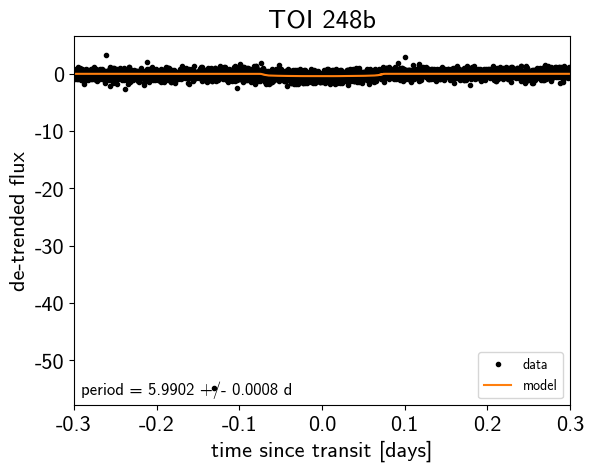

In [11]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

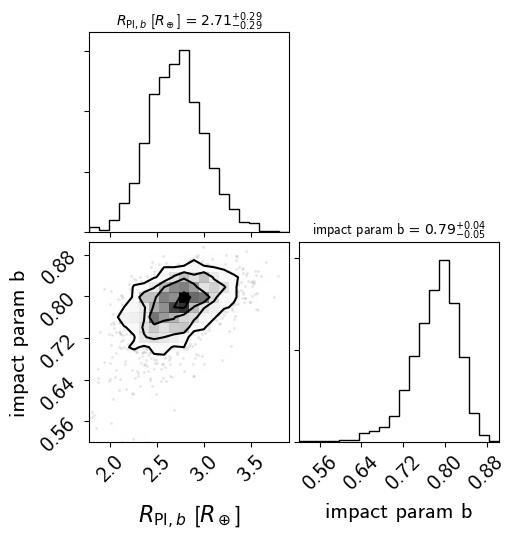

In [12]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

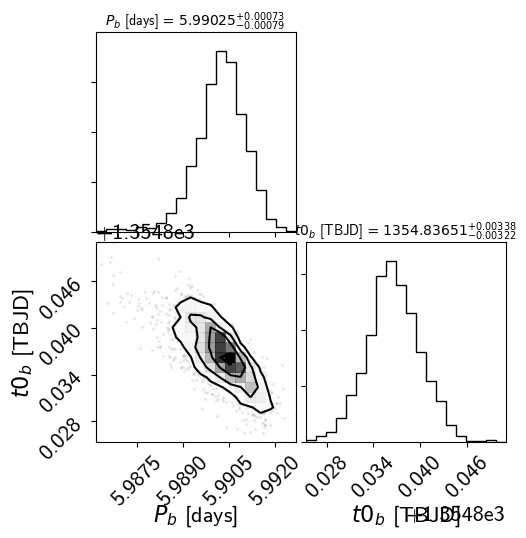

In [13]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

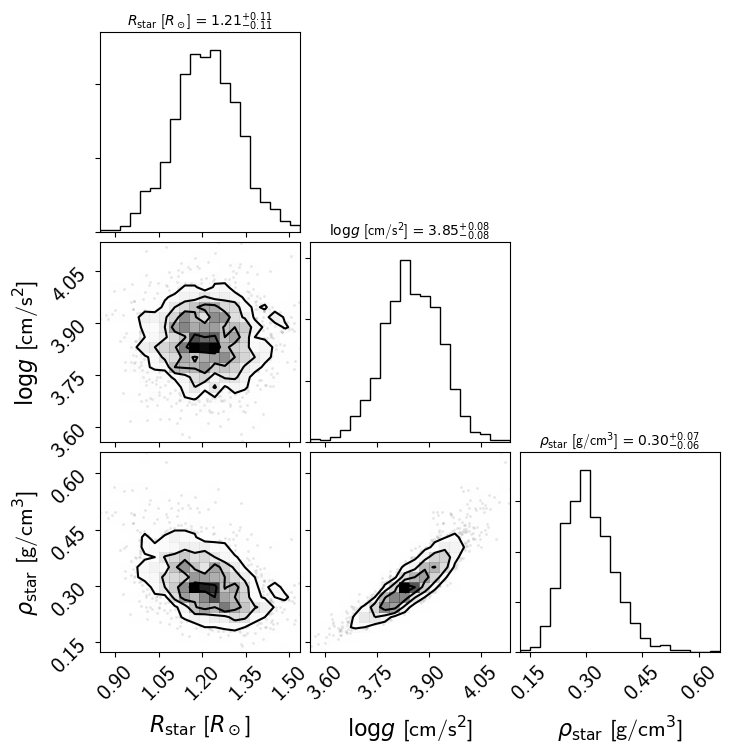

In [14]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [15]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [16]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [17]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3